### Spark notebook ###

This notebook will only work in a Jupyter session running on `mathmadslinux2p`.

You can start your own Jupyter session on `mathmadslinux2p` and open this notebook in Chrome on the MADS Windows server by

**Steps**

1. Login to the MADS Windows server using https://mathportal.canterbury.ac.nz/.
2. Download or copy this notebook to your home directory.
3. Open powershell and run `ssh mathmadslinux2p`.
4. Run `start_pyspark_notebook` or `/opt/anaconda3/bin/jupyter-notebook --ip 132.181.129.68 --port $((8000 + $((RANDOM % 999))))`.
5. Copy / paste the url provided in the shell window into Chrome on the MADS Windows server.
6. Open the notebook from the Jupyter root directory (which is your home directory).
7. Run `start_spark()` to start a spark session in the notebook.
8. Run `stop_spark()` before closing the notebook or kill your spark application by hand using the link in the Spark UI.

In [1]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

### Example notebook ###

The code below provides a template for how you would use a notebook to start spark, run some code, and then stop spark.

**Steps**

- Run `start_spark()` to start a spark session in the notebook (only change the default resources when advised to do so for an exercise or assignment)
- Write and run code interactively, creating additional cells as needed.
- Run `stop_spark()` before closing the notebook or kill your spark application by hand using the link in the [Spark UI](http://mathmadslinux2p.canterbury.ac.nz:8080/).

In [2]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=8, executor_cores=2, worker_memory=8, master_memory=8)

# Processing

## Q1

In [133]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import udf, col, isnull, trim, substring, min, max, countDistinct, when
from pyspark.sql import SparkSession
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re

In [125]:
! hdfs dfs -ls hdfs:///data/ghcnd 

Found 5 items
drwxr-xr-x   - jsw93 jsw93          0 2024-08-21 12:34 hdfs:///data/ghcnd/daily
-rw-r--r--   8 jsw93 jsw93       3659 2024-08-13 14:44 hdfs:///data/ghcnd/ghcnd-countries.txt
-rw-r--r--   8 jsw93 jsw93   34791732 2024-08-13 14:44 hdfs:///data/ghcnd/ghcnd-inventory.txt
-rw-r--r--   8 jsw93 jsw93       1086 2024-08-13 14:44 hdfs:///data/ghcnd/ghcnd-states.txt
-rw-r--r--   8 jsw93 jsw93   11007484 2024-08-13 14:44 hdfs:///data/ghcnd/ghcnd-stations.txt


In [126]:
! hdfs dfs -ls hdfs:///data/ghcnd/daily

Found 263 items
-rw-r--r--   8 jsw93 jsw93    1897634 2024-08-07 01:43 hdfs:///data/ghcnd/daily/1750.csv.gz
-rw-r--r--   8 jsw93 jsw93       3358 2024-08-07 01:44 hdfs:///data/ghcnd/daily/1763.csv.gz
-rw-r--r--   8 jsw93 jsw93       3327 2024-08-07 01:42 hdfs:///data/ghcnd/daily/1764.csv.gz
-rw-r--r--   8 jsw93 jsw93       3335 2024-08-07 01:41 hdfs:///data/ghcnd/daily/1765.csv.gz
-rw-r--r--   8 jsw93 jsw93       3344 2024-08-07 01:38 hdfs:///data/ghcnd/daily/1766.csv.gz
-rw-r--r--   8 jsw93 jsw93       3356 2024-08-07 01:43 hdfs:///data/ghcnd/daily/1767.csv.gz
-rw-r--r--   8 jsw93 jsw93       3325 2024-08-07 01:41 hdfs:///data/ghcnd/daily/1768.csv.gz
-rw-r--r--   8 jsw93 jsw93       3418 2024-08-07 01:41 hdfs:///data/ghcnd/daily/1769.csv.gz
-rw-r--r--   8 jsw93 jsw93       3357 2024-08-07 01:43 hdfs:///data/ghcnd/daily/1770.csv.gz
-rw-r--r--   8 jsw93 jsw93       3373 2024-08-07 01:43 hdfs:///data/ghcnd/daily/1771.csv.gz
-rw-r--r--   8 jsw93 jsw93       3419 2024-08-07 01:42 hdfs:///d

In [127]:
! hdfs dfs -du -h hdfs:///data/ghcnd/daily

1.8 M    14.5 M    hdfs:///data/ghcnd/daily/1750.csv.gz
3.3 K    26.2 K    hdfs:///data/ghcnd/daily/1763.csv.gz
3.2 K    26.0 K    hdfs:///data/ghcnd/daily/1764.csv.gz
3.3 K    26.1 K    hdfs:///data/ghcnd/daily/1765.csv.gz
3.3 K    26.1 K    hdfs:///data/ghcnd/daily/1766.csv.gz
3.3 K    26.2 K    hdfs:///data/ghcnd/daily/1767.csv.gz
3.2 K    26.0 K    hdfs:///data/ghcnd/daily/1768.csv.gz
3.3 K    26.7 K    hdfs:///data/ghcnd/daily/1769.csv.gz
3.3 K    26.2 K    hdfs:///data/ghcnd/daily/1770.csv.gz
3.3 K    26.4 K    hdfs:///data/ghcnd/daily/1771.csv.gz
3.3 K    26.7 K    hdfs:///data/ghcnd/daily/1772.csv.gz
3.3 K    26.3 K    hdfs:///data/ghcnd/daily/1773.csv.gz
3.3 K    26.5 K    hdfs:///data/ghcnd/daily/1774.csv.gz
6.2 K    49.7 K    hdfs:///data/ghcnd/daily/1775.csv.gz
6.3 K    50.2 K    hdfs:///data/ghcnd/daily/1776.csv.gz
6.3 K    50.2 K    hdfs:///data/ghcnd/daily/1777.csv.gz
6.1 K    48.8 K    hdfs:///data/ghcnd/daily/1778.csv.gz
6 K      48 K      hdfs:///data/ghcnd/daily/1779

In [130]:
! hdfs dfs -du -h hdfs:///data/

279.9 M  2.2 G    hdfs:///data/crime
143.8 M  1.1 G    hdfs:///data/fraud
12.5 G   99.8 G   hdfs:///data/ghcnd
1.9 K    7.5 K    hdfs:///data/helloworld
1.2 G    9.4 G    hdfs:///data/ml
12.9 G   103.5 G  hdfs:///data/msd
3.7 M    29.3 M   hdfs:///data/openflights
1.7 M    3.4 M    hdfs:///data/papers
19.1 M   152.9 M  hdfs:///data/shakespeare


In [131]:
! hdfs dfs -du -h hdfs:///data/ghcnd

12.4 G  99.5 G   hdfs:///data/ghcnd/daily
3.6 K   28.6 K   hdfs:///data/ghcnd/ghcnd-countries.txt
33.2 M  265.4 M  hdfs:///data/ghcnd/ghcnd-inventory.txt
1.1 K   8.5 K    hdfs:///data/ghcnd/ghcnd-states.txt
10.5 M  84.0 M   hdfs:///data/ghcnd/ghcnd-stations.txt


In [132]:
# Read the HDFS directory
files_rdd = spark.sparkContext.binaryFiles("hdfs:///data/ghcnd/daily")
files_list = files_rdd.map(lambda x: (x[0], len(x[1]))).collect()

In [134]:
# Extract year from file name and size from content
file_sizes = [(re.search(r'/(\d{4})\.csv\.gz', file).group(1), size) for file, size in files_list]

In [135]:
# Convert to DataFrame
df = pd.DataFrame(file_sizes, columns=['Year', 'Size'])

# Ensure 'Year' is integer and sort by year
df['Year'] = df['Year'].astype(int)
df = df.sort_values('Year')

In [137]:
import plotly.express as px

fig = px.line(df, x='Year', y='Size', title='File Sizes Over Time')
fig.update_layout(xaxis_title='Year', yaxis_title='File Size (bytes)')
fig.show()


## Q2

In [4]:
# Daily Schema Initialization

daily_schema = StructType([
    StructField("ID", StringType(), True),
    StructField("DATE", StringType(), True),
    StructField("ELEMENT", StringType(), True),
    StructField("VALUE", FloatType(), True),
    StructField("MEASUREMENT_FLAG", StringType(), True),
    StructField("QUALITY_FLAG", StringType(), True),
    StructField("SOURCE_FLAG", StringType(), True),
    StructField("OBSERVATION_TIME", StringType(), True)
])


In [5]:
# Loading only 1000 rows

daily_table = (
    spark.read.format("com.databricks.spark.csv")
         .option("header", "false")
         .option("inferschema", "false")
         .schema(daily_schema)
         .load("hdfs:///data/ghcnd/daily/2023.csv.gz")
         .limit(1000)
)
show_as_html(daily_table)

ID      DATE ELEMENT  VALUE MEASUREMENT_FLAG QUALITY_FLAG  \
0   AE000041196  20230101    TMAX  252.0             None         None   
1   AE000041196  20230101    TMIN  149.0             None         None   
2   AE000041196  20230101    PRCP    0.0                D         None   
3   AE000041196  20230101    TAVG  207.0                H         None   
4   AEM00041194  20230101    TMAX  255.0             None         None   
5   AEM00041194  20230101    TMIN  186.0             None         None   
6   AEM00041194  20230101    PRCP    0.0             None         None   
7   AEM00041194  20230101    TAVG  223.0                H         None   
8   AEM00041217  20230101    TMAX  248.0             None         None   
9   AEM00041217  20230101    TMIN  184.0             None         None   
10  AEM00041217  20230101    TAVG  215.0                H         None   
11  AEM00041218  20230101    TMAX  254.0             None         None   
12  AEM00041218  20230101    TMIN  145.0             None         None   
13  AEM00041218  20230101    TAVG  193.0                H         None   
14  AG000060390  20230101    TMIN   47.0             None         None   
15  AG000060390  20230101    TAVG  128.0                H         None   
16  AG000060590  20230101    TAVG  134.0                H         None   
17  AG000060611  20230101    TMIN   24.0             None         None   
18  AG000060611  20230101    TAVG  104.0                H         None   
19  AGE00147708  20230101    TMIN   96.0             None         None   

   SOURCE_FLAG OBSERVATION_TIME  
0            S             None  
1            S             None  
2            S             None  
3            S             None  
4            S             None  
5            S             None  
6            S             None  
7            S             None  
8            S             None  
9            S             None  
10           S             None  
11           S             None  
12           S             None  
13           S             None  
14           S             None  
15           S             None  
16           S             None  
17           S             None  
18           S             None  
19           S             None

In [6]:
spark = SparkSession.builder.appName("GHCN Data Analysis").getOrCreate()

In [7]:
inventory = spark.read.text("hdfs:///data/ghcnd/ghcnd-inventory.txt")
inv = inventory.select(
    substring('value', 1, 11).alias("ID"),
    substring('value', 13, 8).alias("LATITUDE"),
    substring('value', 22, 9).alias("LONGITUDE"),
    substring('value', 32, 4).alias("ELEMENT"),
    substring('value', 37, 4).cast(IntegerType()).alias("FIRST_YEAR"),
    substring('value', 42, 4).cast(IntegerType()).alias("SECOND_YEAR")
)
count_inv = inv.count()
print(f"Number of rows: {count_inv}")
show_as_html(inv, 20)


Number of rows: 756342


ID  LATITUDE  LONGITUDE ELEMENT  FIRST_YEAR  SECOND_YEAR
0   ACW00011604   17.1167   -61.7833    TMAX        1949         1949
1   ACW00011604   17.1167   -61.7833    TMIN        1949         1949
2   ACW00011604   17.1167   -61.7833    PRCP        1949         1949
3   ACW00011604   17.1167   -61.7833    SNOW        1949         1949
4   ACW00011604   17.1167   -61.7833    SNWD        1949         1949
5   ACW00011604   17.1167   -61.7833    PGTM        1949         1949
6   ACW00011604   17.1167   -61.7833    WDFG        1949         1949
7   ACW00011604   17.1167   -61.7833    WSFG        1949         1949
8   ACW00011604   17.1167   -61.7833    WT03        1949         1949
9   ACW00011604   17.1167   -61.7833    WT08        1949         1949
10  ACW00011604   17.1167   -61.7833    WT16        1949         1949
11  ACW00011647   17.1333   -61.7833    TMAX        1961         1961
12  ACW00011647   17.1333   -61.7833    TMIN        1961         1961
13  ACW00011647   17.1333   -61.7833    PRCP        1957         1970
14  ACW00011647   17.1333   -61.7833    SNOW        1957         1970
15  ACW00011647   17.1333   -61.7833    SNWD        1957         1970
16  ACW00011647   17.1333   -61.7833    WT03        1961         1961
17  ACW00011647   17.1333   -61.7833    WT16        1961         1966
18  AE000041196   25.3330    55.5170    TMAX        1944         2024
19  AE000041196   25.3330    55.5170    TMIN        1944         2024

In [8]:
states = spark.read.text("hdfs:///data/ghcnd/ghcnd-states.txt")
state = states.select(
    substring('value', 1, 2).alias("CODE"),
    substring('value', 4, 47).alias("NAME"),
)
count_state = state.count()
print(f"Number of rows: {count_state}")
show_as_html(state, 20)

Number of rows: 74


CODE                                             NAME
0    AB                                          ALBERTA
1    AK                                           ALASKA
2    AL  ALABAMA                                        
3    AR                                         ARKANSAS
4    AS                                   AMERICAN SAMOA
5    AZ                                          ARIZONA
6    BC                                 BRITISH COLUMBIA
7    CA                                       CALIFORNIA
8    CO                                         COLORADO
9    CT                                      CONNECTICUT
10   DC                             DISTRICT OF COLUMBIA
11   DE                                         DELAWARE
12   FL                                          FLORIDA
13   FM                                       MICRONESIA
14   GA                                          GEORGIA
15   GU                                             GUAM
16   HI                                           HAWAII
17   IA                                             IOWA
18   ID                                            IDAHO
19   IL                                         ILLINOIS

In [9]:
countries = spark.read.text("hdfs:///data/ghcnd/ghcnd-countries.txt")
country = countries.select(
    substring('value', 1, 2).alias("CODE"),
    substring('value', 4, 61).alias("NAME"),
)
count_country = country.count()
print(f"Number of rows: {count_country}")
show_as_html(country, 20)

Number of rows: 219


CODE                             NAME
0    AC             Antigua and Barbuda 
1    AE            United Arab Emirates 
2    AF                      Afghanistan
3    AG                         Algeria 
4    AJ                      Azerbaijan 
5    AL                          Albania
6    AM                         Armenia 
7    AO                          Angola 
8    AQ  American Samoa [United States] 
9    AR                       Argentina 
10   AS                       Australia 
11   AU                         Austria 
12   AY                      Antarctica 
13   BA                         Bahrain 
14   BB                        Barbados 
15   BC                        Botswana 
16   BD        Bermuda [United Kingdom] 
17   BE                         Belgium 
18   BF                    Bahamas, The 
19   BG                       Bangladesh

In [10]:
stations = spark.read.text("hdfs:///data/ghcnd/ghcnd-stations.txt")
station = stations.select(
    substring('value', 1, 11).alias("ID"),
    substring('value', 13, 8).alias("LATITUDE"),
    substring('value', 22, 9).alias("LONGITUDE"),
    substring('value', 32, 6).alias("ELEVATION"),
    substring('value', 39, 2).alias("STATE"),
    substring('value', 42, 30).alias("STATION_NAME"),
    substring('value', 73, 3).alias("GSN_FLAG"),
    substring('value', 77, 3).alias("HCN_CRN_FLAG"),
    substring('value', 81, 5).alias("WMO_ID")
)
count_station = station.count()
print(f"Number of rows: {count_station}")
show_as_html(station, 20)

Number of rows: 127994


ID  LATITUDE  LONGITUDE ELEVATION STATE  \
0   ACW00011604   17.1167   -61.7833      10.1         
1   ACW00011647   17.1333   -61.7833      19.2         
2   AE000041196   25.3330    55.5170      34.0         
3   AEM00041194   25.2550    55.3640      10.4         
4   AEM00041217   24.4330    54.6510      26.8         
5   AEM00041218   24.2620    55.6090     264.9         
6   AF000040930   35.3170    69.0170    3366.0         
7   AFM00040938   34.2100    62.2280     977.2         
8   AFM00040948   34.5660    69.2120    1791.3         
9   AFM00040990   31.5000    65.8500    1010.0         
10  AG000060390   36.7167     3.2500      24.0         
11  AG000060590   30.5667     2.8667     397.0         
12  AG000060611   28.0500     9.6331     561.0         
13  AG000060680   22.8000     5.4331    1362.0         
14  AGE00135039   35.7297     0.6500      50.0         
15  AGE00147704   36.9700     7.7900     161.0         
16  AGE00147705   36.7800     3.0700      59.0         
17  AGE00147706   36.8000     3.0300     344.0         
18  AGE00147707   36.8000     3.0400      38.0         
19  AGE00147708   36.7200     4.0500     222.0         

                      STATION_NAME GSN_FLAG HCN_CRN_FLAG WMO_ID  
0   ST JOHNS COOLIDGE FLD                                        
1   ST JOHNS                                                     
2   SHARJAH INTER. AIRP                 GSN               41196  
3   DUBAI INTL                                            41194  
4   ABU DHABI INTL                                        41217  
5   AL AIN INTL                                           41218  
6   NORTH-SALANG                        GSN               40930  
7   HERAT                                                 40938  
8   KABUL INTL                                            40948  
9   KANDAHAR AIRPORT                                      40990  
10  ALGER-DAR EL BEIDA                  GSN               60390  
11  EL-GOLEA                            GSN               60590  
12  IN-AMENAS                           GSN               60611  
13  TAMANRASSET                         GSN               60680  
14  ORAN-HOPITAL MILITAIRE                                       
15  ANNABA-CAP DE GARDE                                          
16  ALGIERS-VILLE/UNIVERSITE                                     
17  ALGIERS-BOUZAREAH                                            
18  ALGIERS-CAP CAXINE                                           
19  TIZI OUZOU                                            60395

In [11]:
# Performing leftanti join to find stations in inventory that are not in stations

missing = inv.join(station, inv.ID == station.ID, "leftanti")
missing.show()

+---+--------+---------+-------+----------+-----------+
| ID|LATITUDE|LONGITUDE|ELEMENT|FIRST_YEAR|SECOND_YEAR|
+---+--------+---------+-------+----------+-----------+
+---+--------+---------+-------+----------+-----------+



# Stations

## Q1

In [12]:
station = station.withColumn("COUNTRY_CODE", substring(station["ID"], 1, 2))
combined_station = station.join(country, station["COUNTRY_CODE"] == country["CODE"], "left")
combined_station = combined_station.drop("CODE")
combined_station = combined_station.withColumnRenamed("NAME", "COUNTRY_NAME")
combined_station = combined_station.join(state, station["STATE"] == state["CODE"], "left")
combined_station = combined_station.drop("CODE")
combined_station = combined_station.withColumnRenamed("NAME", "STATE_NAME")
show_as_html(combined_station.select("STATE_NAME").distinct(), 20)

ID  LATITUDE  LONGITUDE ELEVATION STATE  \
0   ACW00011604   17.1167   -61.7833      10.1         
1   ACW00011647   17.1333   -61.7833      19.2         
2   AE000041196   25.3330    55.5170      34.0         
3   AEM00041194   25.2550    55.3640      10.4         
4   AEM00041217   24.4330    54.6510      26.8         
5   AEM00041218   24.2620    55.6090     264.9         
6   AF000040930   35.3170    69.0170    3366.0         
7   AFM00040938   34.2100    62.2280     977.2         
8   AFM00040948   34.5660    69.2120    1791.3         
9   AFM00040990   31.5000    65.8500    1010.0         
10  AG000060390   36.7167     3.2500      24.0         
11  AG000060590   30.5667     2.8667     397.0         
12  AG000060611   28.0500     9.6331     561.0         
13  AG000060680   22.8000     5.4331    1362.0         
14  AGE00135039   35.7297     0.6500      50.0         
15  AGE00147704   36.9700     7.7900     161.0         
16  AGE00147705   36.7800     3.0700      59.0         
17  AGE00147706   36.8000     3.0300     344.0         
18  AGE00147707   36.8000     3.0400      38.0         
19  AGE00147708   36.7200     4.0500     222.0         

                      STATION_NAME GSN_FLAG HCN_CRN_FLAG WMO_ID COUNTRY_CODE  \
0   ST JOHNS COOLIDGE FLD                                                 AC   
1   ST JOHNS                                                              AC   
2   SHARJAH INTER. AIRP                 GSN               41196           AE   
3   DUBAI INTL                                            41194           AE   
4   ABU DHABI INTL                                        41217           AE   
5   AL AIN INTL                                           41218           AE   
6   NORTH-SALANG                        GSN               40930           AF   
7   HERAT                                                 40938           AF   
8   KABUL INTL                                            40948           AF   
9   KANDAHAR AIRPORT                                      40990           AF   
10  ALGER-DAR EL BEIDA                  GSN               60390           AG   
11  EL-GOLEA                            GSN               60590           AG   
12  IN-AMENAS                           GSN               60611           AG   
13  TAMANRASSET                         GSN               60680           AG   
14  ORAN-HOPITAL MILITAIRE                                                AG   
15  ANNABA-CAP DE GARDE                                                   AG   
16  ALGIERS-VILLE/UNIVERSITE                                              AG   
17  ALGIERS-BOUZAREAH                                                     AG   
18  ALGIERS-CAP CAXINE                                                    AG   
19  TIZI OUZOU                                            60395           AG   

             COUNTRY_NAME STATE_NAME  
0    Antigua and Barbuda        None  
1    Antigua and Barbuda        None  
2   United Arab Emirates        None  
3   United Arab Emirates        None  
4   United Arab Emirates        None  
5   United Arab Emirates        None  
6             Afghanistan       None  
7             Afghanistan       None  
8             Afghanistan       None  
9             Afghanistan       None  
10               Algeria        None  
11               Algeria        None  
12               Algeria        None  
13               Algeria        None  
14               Algeria        None  
15               Algeria        None  
16               Algeria        None  
17               Algeria        None  
18               Algeria        None  
19               Algeria        None

In [13]:
station_years = inv.groupBy(["ID"]).agg(
    min("FIRST_YEAR").alias("FIRST_YEAR_ACTIVE"),
    max("SECOND_YEAR").alias("LAST_YEAR_ACTIVE")
)
station_years = station_years.withColumnRenamed("ID", "STATION_IDDD")
show_as_html(station_years, 20)

STATION_IDDD  FIRST_YEAR_ACTIVE  LAST_YEAR_ACTIVE
0   AGE00147719               1888              2024
1   ALE00100939               1940              2000
2   ARM00087480               1965              2024
3   ASN00002033               1920              1965
4   ASN00004031               1949              1983
5   ASN00006011               1750              2024
6   ASN00006023               1912              2023
7   ASN00006077               1918              1928
8   ASN00007094               1961              2021
9   ASN00007166               1911              1916
10  ASN00008109               1911              2018
11  ASN00008194               1908              1919
12  ASN00009031               1900              2019
13  ASN00009048               1940              1949
14  ASN00009072               1958              2002
15  ASN00009727               1907              1919
16  ASN00009734               1925              1931
17  ASN00009802               1967              2018
18  ASN00009922               1750              2023
19  ASN00010031               1750              2023

In [14]:
station_elements_count = inv.groupBy("ID").agg(
    countDistinct("ELEMENT").alias("ELEMENT_COUNT")
)
station_elements_count = station_elements_count.withColumnRenamed("ID", "STATION_IDDD")
show_as_html(station_elements_count)

STATION_IDDD  ELEMENT_COUNT
0   USC00413992             31
1   USC00414982             21
2   USC00415650             19
3   USC00417983             19
4   USC00418721             24
5   USC00422561             18
6   USC00444148             15
7   USC00447506             18
8   USC00453728             21
9   USC00459238             21
10  USC00479176             20
11  USC00482780             10
12  USC00487760             21
13  USC00500230             22
14  USC00503605             16
15  USC00504964             14
16  USC00509460             16
17  USC00509869             22
18  USR0000OFAL              3
19  USR0000TCOL              3

In [15]:
# Defining core elements
core_elements = ["PRCP", "SNOW", "SNWD", "TMAX", "TMIN"]

# Marking each element as Core or Other
inv = inv.withColumn("ELEMENT_TYPE",
                     when(inv["ELEMENT"].isin(core_elements), "Core").otherwise("Other")
                    )

# Counting
count_core_other = inv.groupBy("ID").pivot("ELEMENT_TYPE").count()
count_core_other = count_core_other.withColumn("CORE", col("Core").cast("int")) \
                                   .withColumn("OTHER", col("Other").cast("int")) \
                                   .fillna(0, subset = ["CORE"]) \
                                   .fillna(0, subset = ["OTHER"]) \
                                   .withColumnRenamed("ID","STATION_IDDD")
show_as_html(count_core_other)


STATION_IDDD  CORE  OTHER
0   US1MDPG0094     2      2
1   US1MNNC0034     2      2
2   US1MOBT0004     3      4
3   US1NCON0034     3      2
4   US1OHDR0011     2      2
5   US1OKMN0005     3      1
6   CA006068980     5      2
7   CA006150100     3      2
8   CA006156470     4      2
9   CA1ON001038     3      2
10  ISE00105694     4      1
11  KZ000036439     4      1
12  KZ000038191     4      1
13  MXN00032025     3      0
14  RSM00031295     4      1
15  US1Brow4379     2      1
16  US1CASA0086     2      2
17  US1COOR0028     2      2
18  US1FLGD0009     2      0
19  US1GATP0004     2      0

In [16]:
# Stations that collected all 5 cores
station_all_core = count_core_other.filter(col("CORE") == 5)
count_station_all_core = station_all_core.count()
print(f"Number of stations that collected all five core elements: {count_station_all_core}")


Number of stations that collected all five core elements: 20482


In [17]:
# Filtering with only those having PRCP as the element
prcp = inv.filter(col("ELEMENT") == "PRCP")

# Getting only those with total elements as 1
prcp = prcp.join(
    station_elements_count,
    prcp["ID"] == station_elements_count["STATION_IDDD"]
).filter(col("ELEMENT_COUNT") == 1)

# Count again
prcp_count = prcp.count()
print(f"Number of stations that collected only preciptation: {prcp_count}")

Number of stations that collected only preciptation: 16308


In [18]:
# Joining the two tables
combined_station = combined_station.join(station_years, station_years["STATION_IDDD"] == combined_station["ID"], "left")
combined_station = combined_station.drop("STATION_IDDD")
show_as_html(combined_station,20)

ID  LATITUDE  LONGITUDE ELEVATION STATE  \
0   AGE00147719   33.7997     2.8900     767.0         
1   ALE00100939   41.3331    19.7831      89.0         
2   ARM00087480  -32.9040   -60.7850      25.9         
3   ASN00002033  -17.8000   128.3000    -999.9         
4   ASN00004031  -20.6267   117.1925      30.0         
5   ASN00006011  -24.8878   113.6700       4.0         
6   ASN00006023  -23.8222   113.5256      20.0         
7   ASN00006077  -25.3000   115.6000    -999.9         
8   ASN00007094  -24.6514   116.1647     299.0         
9   ASN00007166  -28.3500   116.5500    -999.9         
10  ASN00008109  -28.4767   115.7897     330.0         
11  ASN00008194  -30.5000   116.1000    -999.9         
12  ASN00009031  -31.9564   116.1642     190.0         
13  ASN00009048  -32.1000   116.0000    -999.9         
14  ASN00009072  -30.2842   115.5242     200.0         
15  ASN00009727  -34.7000   117.6000    -999.9         
16  ASN00009734  -32.5000   116.0000    -999.9         
17  ASN00009802  -33.6633   121.6306      90.0         
18  ASN00009922  -33.6492   121.1972     110.0         
19  ASN00010031  -31.3742   117.5861     300.0         

                      STATION_NAME GSN_FLAG HCN_CRN_FLAG WMO_ID COUNTRY_CODE  \
0   LAGHOUAT                                              60545           AG   
1   TIRANA                                                                AL   
2   ROSARIO                                               87480           AR   
3   TURNER RIVER                                                          AS   
4   POINT SAMSON                                                          AS   
5   CARNARVON AIRPORT                   GSN               94300           AS   
6   GNARALOO                                                              AS   
7   BOUNDARY STORE                                                        AS   
8   YINNETHARRA                                                           AS   
9   JOHARDO                                                               AS   
10  PINDAR                                                                AS   
11  COOMBERDALE 1                                                         AS   
12  MUNDARING WEIR                                                        AS   
13  GOSNELLS                                                              AS   
14  BUNDIDUP                                                              AS   
15  SAINT WERBURGHS                                                       AS   
16  WHITTAKERS MILL                                                       AS   
17  THE OAKS                                                              AS   
18  WEST LORT RIVER                                                       AS   
19  YORKRAKINE TM                                                         AS   

   COUNTRY_NAME STATE_NAME  FIRST_YEAR_ACTIVE  LAST_YEAR_ACTIVE  
0      Algeria        None               1888              2024  
1       Albania       None               1940              2000  
2    Argentina        None               1965              2024  
3    Australia        None               1920              1965  
4    Australia        None               1949              1983  
5    Australia        None               1750              2024  
6    Australia        None               1912              2023  
7    Australia        None               1918              1928  
8    Australia        None               1961              2021  
9    Australia        None               1911              1916  
10   Australia        None               1911              2018  
11   Australia        None               1908              1919  
12   Australia        None               1900              2019  
13   Australia        None               1940              1949  
14   Australia        None               1958              2002  
15   Australia        None               1907              1919  
16   Australia        None       

In [19]:
# Joining station elements
combined_station = combined_station.join(station_elements_count, station_elements_count["STATION_IDDD"] == combined_station["ID"], "left")
combined_station = combined_station.drop("STATION_IDDD")

In [20]:
# Joining core_other table
combined_station = combined_station.join(count_core_other, count_core_other["STATION_IDDD"] == combined_station["ID"], "left")
combined_station = combined_station.drop("STATION_IDDD")

In [21]:
show_as_html(combined_station,20)

ID  LATITUDE  LONGITUDE ELEVATION STATE  \
0   AGE00147719   33.7997     2.8900     767.0         
1   ALE00100939   41.3331    19.7831      89.0         
2   ARM00087480  -32.9040   -60.7850      25.9         
3   ASN00002033  -17.8000   128.3000    -999.9         
4   ASN00004031  -20.6267   117.1925      30.0         
5   ASN00006011  -24.8878   113.6700       4.0         
6   ASN00006023  -23.8222   113.5256      20.0         
7   ASN00006077  -25.3000   115.6000    -999.9         
8   ASN00007094  -24.6514   116.1647     299.0         
9   ASN00007166  -28.3500   116.5500    -999.9         
10  ASN00008109  -28.4767   115.7897     330.0         
11  ASN00008194  -30.5000   116.1000    -999.9         
12  ASN00009031  -31.9564   116.1642     190.0         
13  ASN00009048  -32.1000   116.0000    -999.9         
14  ASN00009072  -30.2842   115.5242     200.0         
15  ASN00009727  -34.7000   117.6000    -999.9         
16  ASN00009734  -32.5000   116.0000    -999.9         
17  ASN00009802  -33.6633   121.6306      90.0         
18  ASN00009922  -33.6492   121.1972     110.0         
19  ASN00010031  -31.3742   117.5861     300.0         

                      STATION_NAME GSN_FLAG HCN_CRN_FLAG WMO_ID COUNTRY_CODE  \
0   LAGHOUAT                                              60545           AG   
1   TIRANA                                                                AL   
2   ROSARIO                                               87480           AR   
3   TURNER RIVER                                                          AS   
4   POINT SAMSON                                                          AS   
5   CARNARVON AIRPORT                   GSN               94300           AS   
6   GNARALOO                                                              AS   
7   BOUNDARY STORE                                                        AS   
8   YINNETHARRA                                                           AS   
9   JOHARDO                                                               AS   
10  PINDAR                                                                AS   
11  COOMBERDALE 1                                                         AS   
12  MUNDARING WEIR                                                        AS   
13  GOSNELLS                                                              AS   
14  BUNDIDUP                                                              AS   
15  SAINT WERBURGHS                                                       AS   
16  WHITTAKERS MILL                                                       AS   
17  THE OAKS                                                              AS   
18  WEST LORT RIVER                                                       AS   
19  YORKRAKINE TM                                                         AS   

   COUNTRY_NAME STATE_NAME  FIRST_YEAR_ACTIVE  LAST_YEAR_ACTIVE  \
0      Algeria        None               1888              2024   
1       Albania       None               1940              2000   
2    Argentina        None               1965              2024   
3    Australia        None               1920              1965   
4    Australia        None               1949              1983   
5    Australia        None               1750              2024   
6    Australia        None               1912              2023   
7    Australia        None               1918              1928   
8    Australia        None               1961              2021   
9    Australia        None               1911              1916   
10   Australia        None               1911              2018   
11   Australia        None               1908              1919   
12   Australia        None               1900              2019   
13   Australia        None               1940              1949   
14   Australia        None               1958              2002   
15   Australia        None               1907              1919   
16   Australia  

In [22]:
# Writing to output directory
home_diretory = "hdfs:///user/sss135/assignment-1/outputs/"
combined_station.write.mode("overwrite").parquet(f"{home_diretory}stations.parquet")

## Q2

In [162]:
# Creating a Daily table with 1000 rows
daily_table = (
    spark.read.format("com.databricks.spark.csv")
         .option("header", "false")
         .option("inferschema", "false")
         .schema(daily_schema)
         .load("hdfs:///data/ghcnd/daily/*.csv.gz")
         .limit(1000)
)

In [174]:
# Renaming the ID inorder to avoid duplicating
daily_table = daily_table.withColumnRenamed("ID", "DELETE_ME")

# Joining tables
station_daily = combined_station.join(daily_table, daily_table["DELETE_ME"] == combined_station["ID"], "left")

# Finding the missing ones
missing = station_daily.filter(col("DELETE_ME").isNull())

# Counting them
missing = missing.select("ID").distinct().count()

# Droping the extra column
station_daily = station_daily.drop("DELETE_ME")
print(f"Number of stations that are not in the subset of daily: {missing}")

Number of stations that are not in the subset of daily: 127424


In [25]:
# Creating a Daily table with all the values
daily_table = (
    spark.read.format("com.databricks.spark.csv")
         .option("header", "false")
         .option("inferschema", "false")
         .schema(daily_schema)
         .load("hdfs:///data/ghcnd/daily/*.csv.gz")
)

In [26]:
# Renaming ID to avoid duplicating
daily_table = daily_table.withColumnRenamed("ID", "DELETE_ME")

# Joining the two tables
station_daily = combined_station.join(daily_table, daily_table["DELETE_ME"] == combined_station["ID"], "left")

# Finding the missing ones
missing = station_daily.filter(col("DELETE_ME").isNull())

# Counting them
missing = missing.select("ID").distinct().count()

# Droping the extra column
station_daily = station_daily.drop("DELETE_ME")
print(f"Number of stations that are not in the subset of daily: {missing}")

Number of stations that are not in the subset of daily: 8


# Daily

## Q1

In [148]:
! hdfs dfs -du hdfs:///data/ghcnd/daily/2024.csv.gz
! hdfs dfs -du hdfs:///data/ghcnd/daily/2023.csv.gz

88831735  710653880  hdfs:///data/ghcnd/daily/2024.csv.gz
168357302  1346858416  hdfs:///data/ghcnd/daily/2023.csv.gz


In [146]:
! hdfs getconf -confKey "dfs.blocksize"

134217728


In [154]:
! hdfs dfs -stat %b hdfs:///data/ghcnd/daily/2024.csv.gz
! hdfs dfs -stat %b hdfs:///data/ghcnd/daily/2023.csv.gz

88831735
168357302


In [157]:
default_block_size = 134217728  
file_size_2024 = 88831735   
file_size_2023 = 168357302    

# Calculate the number of blocks
num_blocks_2024 = math.ceil(file_size_2024 / default_block_size)
num_blocks_2023 = math.ceil(file_size_2023 / default_block_size)

print(f"Number of blocks for 2024: {num_blocks_2024}")
print(f"Number of blocks for 2023: {num_blocks_2023}")

Number of blocks for 2024: 1
Number of blocks for 2023: 2


In [159]:
! hdfs fsck hdfs:///data/ghcnd/daily/2023.csv.gz -files -blocks -locations

Connecting to namenode via http://masternode2:9870/fsck?ugi=sss135&files=1&blocks=1&locations=1&path=%2Fdata%2Fghcnd%2Fdaily%2F2023.csv.gz
FSCK started by sss135 (auth:SIMPLE) from /192.168.40.11 for path /data/ghcnd/daily/2023.csv.gz at Thu Sep 12 01:50:35 NZST 2024

/data/ghcnd/daily/2023.csv.gz 168357302 bytes, replicated: replication=8, 2 block(s):  OK
0. BP-700027894-132.181.129.68-1626517177804:blk_1074220535_479735 len=134217728 Live_repl=8  [DatanodeInfoWithStorage[192.168.40.159:9866,DS-93ea3ab4-4367-4d25-8560-df00f71281a3,DISK], DatanodeInfoWithStorage[192.168.40.136:9866,DS-9d6d27e6-ba50-4de0-b616-5a345ab60e3b,DISK], DatanodeInfoWithStorage[192.168.40.182:9866,DS-e4f2f808-1c7b-4fd2-a801-fbd7c1393dea,DISK], DatanodeInfoWithStorage[192.168.40.105:9866,DS-995c6d40-6fd7-4f6e-8812-148b6aac3e9f,DISK], DatanodeInfoWithStorage[192.168.40.145:9866,DS-eb2f3e76-2e2c-4bb9-98ff-2eb86c531a80,DISK], DatanodeInfoWithStorage[192.168.40.173:9866,DS-81ea4712-59d5-45a7-8d68-848697c8fac8,DISK], 

In [175]:
# Daily table for 2023 all observations
daily_table_2023 = (
    spark.read.format("com.databricks.spark.csv")
         .option("header", "false")
         .option("inferschema", "false")
         .schema(daily_schema)
         .load("hdfs:///data/ghcnd/daily/2023.csv.gz")
)
print(f"The number of observations in 2023: {daily_table_2023.count()}")

The number of observations in 2023: 37867272


In [176]:
# Daily tables for 2024 for all observations
daily_table_2024 = (
    spark.read.format("com.databricks.spark.csv")
         .option("header", "false")
         .option("inferschema", "false")
         .schema(daily_schema)
         .load("hdfs:///data/ghcnd/daily/2024.csv.gz")
)
print(f"The number of observations in 2024: {daily_table_2024.count()}")

The number of observations in 2024: 19720790


In [177]:
# Finding the number of tasks required
num_partitions_2023 = daily_table_2023.rdd.getNumPartitions()
num_partitions_2024 = daily_table_2024.rdd.getNumPartitions()

print(f"Number of partitions for 2023 data: {num_partitions_2023}")
print(f"Number of partitions for 2024 data: {num_partitions_2024}")

Number of partitions for 2023 data: 1
Number of partitions for 2024 data: 1


In [30]:
# Daily table from 2014 to 2023 (inclusive)
daily_table_2014_2023 = (
    spark.read.format("com.databricks.spark.csv")
         .option("header", "false")
         .option("inferschema", "false")
         .schema(daily_schema)
         .load("hdfs:///data/ghcnd/daily/20{1[4-9],2[0-3]}*.csv.gz")
)
print(f"The number of observations from 2014 to 2023 (inclusive): {daily_table_2014_2023.count()}")

The number of observations from 2014 to 2023 (inclusive): 370803270


# Analysis

## Q1

In [31]:
# Total stations count
total_stations = combined_station.select("ID").distinct().count()
print(f"Total number of stations: {total_stations}")

Total number of stations: 127994


In [32]:
# Still active count
active_stations =combined_station.filter(col("LAST_YEAR_ACTIVE") >= 2024).select("ID").distinct().count()
print(f"Number of stations that are still actve: {active_stations}")

Number of stations that are still actve: 36516


In [33]:
# GSN
station_GSN = combined_station.filter(col("GSN_FLAG") == "GSN").select("ID").distinct().count()
print(f"Number of stations in GCOS Surface Network (GSN): {station_GSN}")

Number of stations in GCOS Surface Network (GSN): 991


In [34]:
# HCN
station_HCN = combined_station.filter(col("HCN_CRN_FLAG") == "HCN").select("ID").distinct().count()
print(f"Number of stations in US Historical Climatology Network (HCN): {station_HCN}")

Number of stations in US Historical Climatology Network (HCN): 1218


In [35]:
# CRN
station_CRN = combined_station.filter(col("HCN_CRN_FLAG") == "CRN").select("ID").distinct().count()
print(f"Number of stations in US Climate Reference Network (CRN): {station_CRN}")

Number of stations in US Climate Reference Network (CRN): 234


In [36]:
# Counting the stations with more than one network
station_more = combined_station.filter(
    (col("GSN_FLAG") == "GSN") &
    ((col("HCN_CRN_FLAG") == "HCN") | (col("HCN_CRN_FLAG") == "CRN"))
).select("ID").distinct().count()

print(f"Number of stations in more than one network: {station_more}")

Number of stations in more than one network: 15


In [37]:
# Filtering out the souther hemisphere countries
southern_stations = combined_station.filter(
    col("LATITUDE").cast("float") < 0
).select("ID").distinct().count()

print(f"Number of stations in the Southern Hemisphere: {southern_stations}")

Number of stations in the Southern Hemisphere: 25357


In [38]:
# FIltering out the countries that are not in US but belongs to United States Territories
not_us = combined_station.filter(
                    (col("COUNTRY_NAME").contains("United States")) &
                    (col("COUNTRY_CODE") != "US")
                ).distinct().select("ID").count()

print(f"Number of stations in US territories (excluding the ones in United States): {not_us}")

Number of stations in US territories (excluding the ones in United States): 399


In [39]:
# Grouping each country
each_country = combined_station.groupBy("COUNTRY_NAME").agg(
    countDistinct("ID").alias("STATION_COUNT")
)

# Renaming to avoid same name for columns
each_country = each_country.withColumnRenamed("COUNTRY_NAME", "DELETE_ME")

# Joining the two tables
country = country.join(each_country, each_country["DELETE_ME"] == country["NAME"])

# Droping the extra column
country = country.drop("DELETE_ME")

In [40]:
show_as_html(country)

CODE                     NAME  STATION_COUNT
0    IR                    Iran              35
1    SW                  Sweden            1721
2    BL                 Bolivia              36
3    WZ               Swaziland               6
4    EK        Equatorial Guinea              2
5    AG                 Algeria              87
6    AS               Australia           17088
7    CE               Sri Lanka               6
8    MR              Mauritania              19
9    NH                 Vanuatu               6
10   RW                   Rwanda              1
11   BN                   Benin               9
12   CH                  China              228
13   SY                   Syria              12
14   NC  New Caledonia [France]               3
15   TL   Tokelau [New Zealand]               1
16   GB                   Gabon              20
17   PK                Pakistan              35
18   PS                    Palau             12
19   MP               Mauritius               5

In [41]:
# Grouping each state
each_state = combined_station.groupBy("STATE_NAME").agg(
    countDistinct("ID").alias("STATION_COUNT")
)

# Renaming to avoid same name for columns
each_state = each_state.withColumnRenamed("STATE_NAME", "DELETE_ME")

# Joining the two tables
state = state.join(each_state, each_state["DELETE_ME"] == state["NAME"])

# Droping the extra column
state = state.drop("DELETE_ME")

In [42]:
show_as_html(state)

CODE                         NAME  STATION_COUNT
0    TN                    TENNESSEE           1700
1    AK                       ALASKA           1046
2    CO                     COLORADO           4735
3    ND                 NORTH DAKOTA            580
4    ON                      ONTARIO           2010
5    NL    NEWFOUNDLAND AND LABRADOR            335
6    NC               NORTH CAROLINA           2692
7    OH                         OHIO           1444
8    MH             MARSHALL ISLANDS             21
9    FL                      FLORIDA           2205
10   MN                    MINNESOTA           2386
11   CT                  CONNECTICUT            430
12   SD                 SOUTH DAKOTA           1154
13   LA                    LOUISIANA            836
14   NS                  NOVA SCOTIA            393
15   PR                  PUERTO RICO            253
16   UM  U.S. MINOR OUTLYING ISLANDS             11
17   RI                 RHODE ISLAND            239
18   MB                     MANITOBA            734
19   VT                      VERMONT            394

In [43]:
# Writing the output to home directory
state.write.mode("overwrite").parquet(f"{home_diretory}states.parquet")
country.write.mode("overwrite").parquet(f"{home_diretory}country.parquet")

## Q2

In [44]:
# Function for finding the Haversine distance
def haversine(lon1, lat1, lon2, lat2):
    
    # Radius of the Earth in kilometres
    R = 6371.0
    
    # Convert latitude and longitude from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    
    # Compute the difference
    diff_lat = lat2_rad - lat1_rad
    diff_lon = lon2_rad - lon1_rad
    
    # Haversine formula
    a = math.sin(diff_lat / 2) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(diff_lon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = R * c
    
    return distance

In [45]:
# Register the UDF
haversine_udf = udf(haversine, DoubleType())

# Converting the string type lat and lon to double type
station = station.withColumn("LATITUDE", col("LATITUDE").cast(DoubleType())) \
                 .withColumn("LONGITUDE", col("LONGITUDE").cast(DoubleType()))

# Filtering out just New Zealand stations
station_nz_1 = station.filter(col("COUNTRY_CODE") == "NZ")

# Renaming the columns so that it doesn't show problems while writing to outputs directory
station_nz_1 = station_nz_1.withColumnRenamed("ID", "ID_1") \
                      .withColumnRenamed("LATITUDE", "LATITUDE_1") \
                      .withColumnRenamed("LONGITUDE", "LONGITUDE_1") \
                      .withColumnRenamed("ELEVATION", "ELEVATION_1") \
                      .withColumnRenamed("STATE", "STATE_1") \
                      .withColumnRenamed("STATION_NAME", "STATION_NAME_1") \
                      .withColumnRenamed("GSN_FLAG", "GSN_FLAG_1") \
                      .withColumnRenamed("HCN_CRN_FLAG", "HCN_CRN_FLAG_1") \
                      .withColumnRenamed("WMO_ID", "WMO_ID_1") \
                      .withColumnRenamed("COUNTRY_CODE", "COUNTRY_CODE_1")

# Renaming the columns so that it doesn't show problems while writing to outputs directory
station_nz_2 = station_nz_1.withColumnRenamed("ID_1", "ID_2") \
                      .withColumnRenamed("LATITUDE_1", "LATITUDE_2") \
                      .withColumnRenamed("LONGITUDE_1", "LONGITUDE_2") \
                      .withColumnRenamed("ELEVATION_1", "ELEVATION_2") \
                      .withColumnRenamed("STATE_1", "STATE_2") \
                      .withColumnRenamed("STATION_NAME_1", "STATION_NAME_2") \
                      .withColumnRenamed("GSN_FLAG_1", "GSN_FLAG_2") \
                      .withColumnRenamed("HCN_CRN_FLAG_1", "HCN_CRN_FLAG_2") \
                      .withColumnRenamed("WMO_ID_1", "WMO_ID_2") \
                      .withColumnRenamed("COUNTRY_CODE_1", "COUNTRY_CODE_2")

# Cross join the dataframe with itself to computepairwise distances
station_cross = station_nz_1.alias("station1").crossJoin(station_nz_2.alias("station2"))

# Compute distances between pairs of stations
distances = station_cross.withColumn(
    "DISTANCE_KM",
    haversine_udf(
    col("station1.LONGITUDE_1"),
    col("station1.LATITUDE_1"),
    col("station2.LONGITUDE_2"),
    col("station2.LATITUDE_2")    
    )
)
show_as_html(distances)

ID_1  LATITUDE_1  LONGITUDE_1 ELEVATION_1 STATE_1  \
0   NZ000093012      -35.10      173.267        54.0           
1   NZ000093012      -35.10      173.267        54.0           
2   NZ000093012      -35.10      173.267        54.0           
3   NZ000093012      -35.10      173.267        54.0           
4   NZ000093012      -35.10      173.267        54.0           
5   NZ000093012      -35.10      173.267        54.0           
6   NZ000093012      -35.10      173.267        54.0           
7   NZ000093012      -35.10      173.267        54.0           
8   NZ000093012      -35.10      173.267        54.0           
9   NZ000093012      -35.10      173.267        54.0           
10  NZ000093012      -35.10      173.267        54.0           
11  NZ000093012      -35.10      173.267        54.0           
12  NZ000093012      -35.10      173.267        54.0           
13  NZ000093012      -35.10      173.267        54.0           
14  NZ000093012      -35.10      173.267        54.0           
15  NZ000093292      -38.65      177.983         5.0           
16  NZ000093292      -38.65      177.983         5.0           
17  NZ000093292      -38.65      177.983         5.0           
18  NZ000093292      -38.65      177.983         5.0           
19  NZ000093292      -38.65      177.983         5.0           

                    STATION_NAME_1 GSN_FLAG_1 HCN_CRN_FLAG_1 WMO_ID_1  \
0   KAITAIA                                                     93119   
1   KAITAIA                                                     93119   
2   KAITAIA                                                     93119   
3   KAITAIA                                                     93119   
4   KAITAIA                                                     93119   
5   KAITAIA                                                     93119   
6   KAITAIA                                                     93119   
7   KAITAIA                                                     93119   
8   KAITAIA                                                     93119   
9   KAITAIA                                                     93119   
10  KAITAIA                                                     93119   
11  KAITAIA                                                     93119   
12  KAITAIA                                                     93119   
13  KAITAIA                                                     93119   
14  KAITAIA                                                     93119   
15  GISBORNE AERODROME                    GSN                   93292   
16  GISBORNE AERODROME                    GSN                   93292   
17  GISBORNE AERODROME                    GSN                   93292   
18  GISBORNE AERODROME                    GSN                   93292   
19  GISBORNE AERODROME                    GSN                   93292   

   COUNTRY_CODE_1     ...      LATITUDE_2  LONGITUDE_2  ELEVATION_2 STATE_2  \
0              NZ     ...         -35.100      173.267         54.0           
1              NZ     ...         -38.650      177.983          5.0           
2              NZ     ...         -40.900      174.983          7.0           
3              NZ     ...         -46.417      168.333          2.0           
4              NZ     ...         -29.250     -177.917         49.0           
5              NZ     ...         -39.017      174.183         32.0           
6              NZ     ...         -42.717      170.983         40.0           
7              NZ     ...         -44.517      169.900        488.0           
8              NZ     ...         -52.550      169.167         19.0           
9              NZ     ...         -43.950     -176.567         49.0           
10             NZ     ...         -37.000      174.800          7.0           
11             NZ     ...         -41.333      174.800         12.0           
12             NZ     ...         -42.417      173.700        101.0           
13             NZ     ... 

In [46]:
distances.write.mode("overwrite").parquet(f"{home_diretory}distances_nz.parquet")

In [183]:
least_distance = distances.dropDuplicates(["DISTANCE_KM"]).orderBy(col("DISTANCE_KM").asc()).collect()
print(f"The two stations that are geographically close together in New Zealand are {least_distance[1]['STATION_NAME_1']} and {least_distance[1]['STATION_NAME_2']} of a distance apart of {least_distance[1]['DISTANCE_KM']}")

The two stations that are geographically close together in New Zealand are PARAPARAUMU AWS                and WELLINGTON AERO AWS            of a distance apart of 50.52902648213863


## Q3

In [48]:
# Renaming ID to avoid duplicating
daily_table = daily_table.withColumnRenamed("DELETE_ME", "ID")

# Counting the number of rows
daily_count = daily_table.count()
print(f"Number of rows in daily: {daily_count}")

Number of rows in daily: 3119374043


In [49]:
# Filtering out core elements
daily_filtered = daily_table.filter(col("ELEMENT").isin(core_elements))
show_as_html(daily_filtered)

ID      DATE ELEMENT  VALUE MEASUREMENT_FLAG QUALITY_FLAG  \
0   AE000041196  20100101    TMAX  259.0             None         None   
1   AE000041196  20100101    TMIN  120.0             None         None   
2   AEM00041194  20100101    TMAX  250.0             None         None   
3   AEM00041194  20100101    TMIN  168.0             None         None   
4   AEM00041194  20100101    PRCP    0.0             None         None   
5   AEM00041217  20100101    TMAX  250.0             None         None   
6   AEM00041217  20100101    TMIN  146.0             None         None   
7   AEM00041218  20100101    TMAX  265.0             None         None   
8   AG000060390  20100101    TMAX  180.0             None         None   
9   AG000060390  20100101    PRCP    0.0             None         None   
10  AG000060590  20100101    TMAX  240.0             None         None   
11  AG000060590  20100101    TMIN   40.0             None         None   
12  AG000060590  20100101    PRCP    0.0             None         None   
13  AG000060611  20100101    TMAX  278.0             None         None   
14  AG000060611  20100101    TMIN   63.0             None         None   
15  AG000060611  20100101    PRCP    0.0             None         None   
16  AGE00147708  20100101    PRCP    5.0             None         None   
17  AGE00147716  20100101    TMAX  173.0             None         None   
18  AGE00147716  20100101    TMIN  143.0             None         None   
19  AGE00147716  20100101    PRCP    5.0             None         None   

   SOURCE_FLAG OBSERVATION_TIME  
0            S             None  
1            S             None  
2            S             None  
3            S             None  
4            S             None  
5            S             None  
6            S             None  
7            S             None  
8            S             None  
9            S             None  
10           S             None  
11           S             None  
12           S             None  
13           S             None  
14           S             None  
15           S             None  
16           S             None  
17           S             None  
18           S             None  
19           S             None

In [50]:
# Grouping the element cores to get the count
observations_count = daily_filtered.groupBy("ELEMENT").count()
show_as_html(observations_count)

ELEMENT       count
0    PRCP  1073530896
1    TMAX   457927581
2    SNWD   299076145
3    SNOW   356187192
4    TMIN   456739567

In [51]:
# Finding the one with most observations
most_observations = observations_count.orderBy(col("count").desc()).first()
print(f"The core element with most observation is {most_observations['ELEMENT']} with a count of {most_observations['count']}")

The core element with most observation is PRCP with a count of 1073530896


In [52]:
# FIltering out the TMAX datas and the TMIN data
tmax = daily_filtered.filter(col("ELEMENT") == "TMAX").select("ID", "DATE")
tmin = daily_filtered.filter(col("ELEMENT") == "TMIN").select("ID", "DATE")

# Now we find the missing datas using leftanti
tmax_no_tmin = tmax.join(tmin, on = ["ID", "DATE"], how = "leftanti")
show_as_html(tmax_no_tmin)

ID      DATE
0   AE000041196  19560704
1   AE000041196  19580617
2   AE000041196  19770904
3   AE000041196  19780117
4   AE000041196  19780619
5   AE000041196  19790420
6   AE000041196  19790609
7   AE000041196  19790719
8   AE000041196  19791211
9   AE000041196  19800113
10  AE000041196  19800212
11  AE000041196  19800305
12  AE000041196  19800418
13  AE000041196  19800513
14  AE000041196  19800822
15  AE000041196  19800918
16  AE000041196  19810109
17  AE000041196  19810521
18  AE000041196  19810528
19  AE000041196  19810614

In [53]:
# Counting it
tmax_no_tmin_count = tmax_no_tmin.count()
print(f"Number of TMAX observations without a corresponding TMIN: {tmax_no_tmin_count}")

Number of TMAX observations without a corresponding TMIN: 10567304


In [54]:
# Finding the distinct station count
tmax_no_tmin_distinct = tmax_no_tmin.select("ID").distinct().count()
print(f"Number of unique stations contributing to these observations: {tmax_no_tmin_distinct}")

Number of unique stations contributing to these observations: 28716


# Visualization

## Q1

In [55]:
# FIltering out the data that is in New Zealand
daily_table_nz = daily_table.filter(col("ID").startswith("NZ"))

daily_table_nz_tmin_tmax = daily_table_nz.filter(col("ELEMENT").isin("TMIN","TMAX"))
show_as_html(daily_table_nz_tmin_tmax)

ID      DATE ELEMENT  VALUE MEASUREMENT_FLAG QUALITY_FLAG  \
0   NZ000093292  20100101    TMAX  297.0             None         None   
1   NZ000093292  20100101    TMIN   74.0             None         None   
2   NZ000093417  20100101    TMAX  180.0             None         None   
3   NZ000093417  20100101    TMIN  125.0             None         None   
4   NZ000093844  20100101    TMAX  232.0             None         None   
5   NZ000093844  20100101    TMIN   96.0             None         None   
6   NZ000933090  20100101    TMAX  197.0             None         None   
7   NZ000933090  20100101    TMIN   82.0             None         None   
8   NZ000936150  20100101    TMAX  324.0             None         None   
9   NZM00093110  20100101    TMAX  215.0             None         None   
10  NZM00093110  20100101    TMIN  153.0             None         None   
11  NZM00093439  20100101    TMAX  204.0             None         None   
12  NZM00093439  20100101    TMIN  134.0             None         None   
13  NZM00093678  20100101    TMAX  242.0             None         None   
14  NZM00093678  20100101    TMIN   94.0             None         None   
15  NZM00093781  20100101    TMAX  324.0             None         None   
16  NZ000093292  20100102    TMAX  302.0             None         None   
17  NZ000093292  20100102    TMIN  180.0             None         None   
18  NZ000093417  20100102    TMAX  181.0             None         None   
19  NZ000093417  20100102    TMIN  153.0             None         None   

   SOURCE_FLAG OBSERVATION_TIME  
0            S             None  
1            S             None  
2            S             None  
3            S             None  
4            S             None  
5            S             None  
6            S             None  
7            S             None  
8            S             None  
9            S             None  
10           S             None  
11           S             None  
12           S             None  
13           S             None  
14           S             None  
15           S             None  
16           S             None  
17           S             None  
18           S             None  
19           S             None

In [56]:
daily_table_nz_tmin_tmax.write.mode("overwrite").parquet(f"{home_diretory}NZ_TMIN_TMAX_Daily.parquet")

In [57]:
print(f"Number of observations of TMIN and TMAX for all stations in New Zealand: {daily_table_nz_tmin_tmax.count()}")

Number of observations of TMIN and TMAX for all stations in New Zealand: 487760


In [59]:
# Convert to Pandas DataFrame
nz_pandas_daily = daily_table_nz_tmin_tmax.toPandas()
nz_pandas_daily['DATE'] = pd.to_datetime(nz_pandas_daily['DATE'])

In [60]:
# Ensure VALUE column is numeric
nz_pandas_daily['VALUE'] = pd.to_numeric(nz_pandas_daily['VALUE'], errors='coerce')

In [61]:
# Pivoting to obtain the TMIN and TMAX as seperate columns
nz_pandas_daily = nz_pandas_daily.pivot_table(index=['ID', 'DATE'], columns='ELEMENT', values='VALUE').reset_index()

In [62]:
# Extract year and month from 'DATE' for grouping
nz_pandas_daily['YearMonth'] = nz_pandas_daily['DATE'].dt.to_period('M')

# Sort values to ensure proper plotting order
nz_pandas_daily = nz_pandas_daily.sort_values(['ID', 'YearMonth'])

# Group by 'ID' and 'YearMonth' to compute the average TMIN and TMAX for each month
monthly_avg = nz_pandas_daily.groupby(['ID', 'YearMonth']).agg({
    'TMIN': 'mean',
    'TMAX': 'mean'
}).rename(columns={'TMIN': 'TMIN_AVG_YM', 'TMAX': 'TMAX_AVG_YM'}).reset_index()

In [63]:
# Handle gaps: We can use forward fill/backward fill to indicate missing data visually
monthly_avg['TMIN_AVG_YM'] = monthly_avg['TMIN_AVG_YM'].interpolate(method='linear')
monthly_avg['TMIN_AVG_YM'] = monthly_avg['TMIN_AVG_YM'].interpolate(method='linear')

# Convert 'YearMonth' back to datetime format for easier plotting
monthly_avg['YearMonth'] = monthly_avg['YearMonth'].dt.to_timestamp()

In [64]:
display(monthly_avg)

ID  YearMonth  TMIN_AVG_YM  TMAX_AVG_YM
0     NZ000093012 1966-01-01   167.566666   223.086960
1     NZ000093012 1966-02-01   180.076920   244.639999
2     NZ000093012 1966-03-01   155.827591   225.129028
3     NZ000093012 1966-04-01   118.785713   196.307693
4     NZ000093012 1966-05-01    81.090912   158.241379
5     NZ000093012 1966-06-01    73.916664   144.576920
6     NZ000093012 1966-07-01    73.421051   135.592590
7     NZ000093012 1966-08-01    60.523811   136.307693
8     NZ000093012 1966-09-01    91.076920   154.199997
9     NZ000093012 1966-10-01    99.333336   173.769226
10    NZ000093012 1966-11-01   128.517242   184.279999
11    NZ000093012 1966-12-01   139.206894   201.461533
12    NZ000093012 1967-01-01   149.633331   214.080002
13    NZ000093012 1967-02-01   143.347824   224.083328
14    NZ000093012 1967-03-01   148.464279   221.333328
15    NZ000093012 1967-04-01   128.919998   199.833328
16    NZ000093012 1967-05-01   101.125000   167.035721
17    NZ000093012 1967-06-01    61.380951   136.250000
18    NZ000093012 1967-07-01    70.639999   139.666672
19    NZ000093012 1967-08-01    90.130432   156.520004
20    NZ000093012 1967-09-01    88.416664   154.846161
21    NZ000093012 1967-10-01   116.866669   188.185181
22    NZ000093012 1967-11-01   135.714279   199.142853
23    NZ000093012 1967-12-01   151.500000   212.520004
24    NZ000093012 1968-01-01   156.379303   218.125000
25    NZ000093012 1968-02-01   148.285721   225.041672
26    NZ000093012 1968-03-01   165.310349   243.500000
27    NZ000093012 1968-04-01   130.520004   188.919998
28    NZ000093012 1968-05-01    99.800003   168.892853
29    NZ000093012 1968-06-01    91.846153   143.000000
...           ...        ...          ...          ...
8792  NZM00093929 2022-03-01    78.032257   129.160004
8793  NZM00093929 2022-04-01    71.333336   118.823532
8794  NZM00093929 2022-05-01    66.777779   109.500000
8795  NZM00093929 2022-06-01    39.000000    91.318184
8796  NZM00093929 2022-07-01    35.277779    80.000000
8797  NZM00093929 2022-08-01    41.625000    94.478264
8798  NZM00093929 2022-09-01    44.299999    99.080002
8799  NZM00093929 2022-10-01    48.923077   103.869568
8800  NZM00093929 2022-11-01    66.533333   121.500000
8801  NZM00093929 2022-12-01    72.548386   132.000000
8802  NZM00093929 2023-01-01    84.967743   146.600006
8803  NZM00093929 2023-02-01    92.892860   145.639999
8804  NZM00093929 2023-03-01    80.266670   132.347824
8805  NZM00093929 2023-04-01    76.812500   124.545456
8806  NZM00093929 2023-05-01    58.333332   111.380951
8807  NZM00093929 2023-06-01    57.000000   100.095238
8808  NZM00093929 2023-07-01    40.294117    91.095238
8809  NZM00093929 2023-08-01    42.937500    94.111115
8810  NZM00093929 2023-09-01    44.333332   102.000000
8811  NZM00093929 2023-10-01    42.966667   105.894737
8812  NZM00093929 2023-11-01    55.206898   117.625000
8813  NZM00093929 2023-12-01    68.129036   124.519997
8814  NZM00093929 2024-01-01    80.033333   133.478256
8815  NZM00093929 2024-02-01    82.827583   133.826080
8816  NZM00093929 2024-03-01    64.480003   120.285713
8817  NZM00093929 2024-04-01    69.944443   115.736839
8818  NZM00093929 2024-05-01    51.105263    97.250000
8819  NZM00093929 2024-06-01    50.555557    94.315788
8820  NZM00093929 2024-07-01    56.437500    94.956520
8821  NZM00093929 2024-08-01    39.500000    96.666664

[8822 rows x 4 columns]

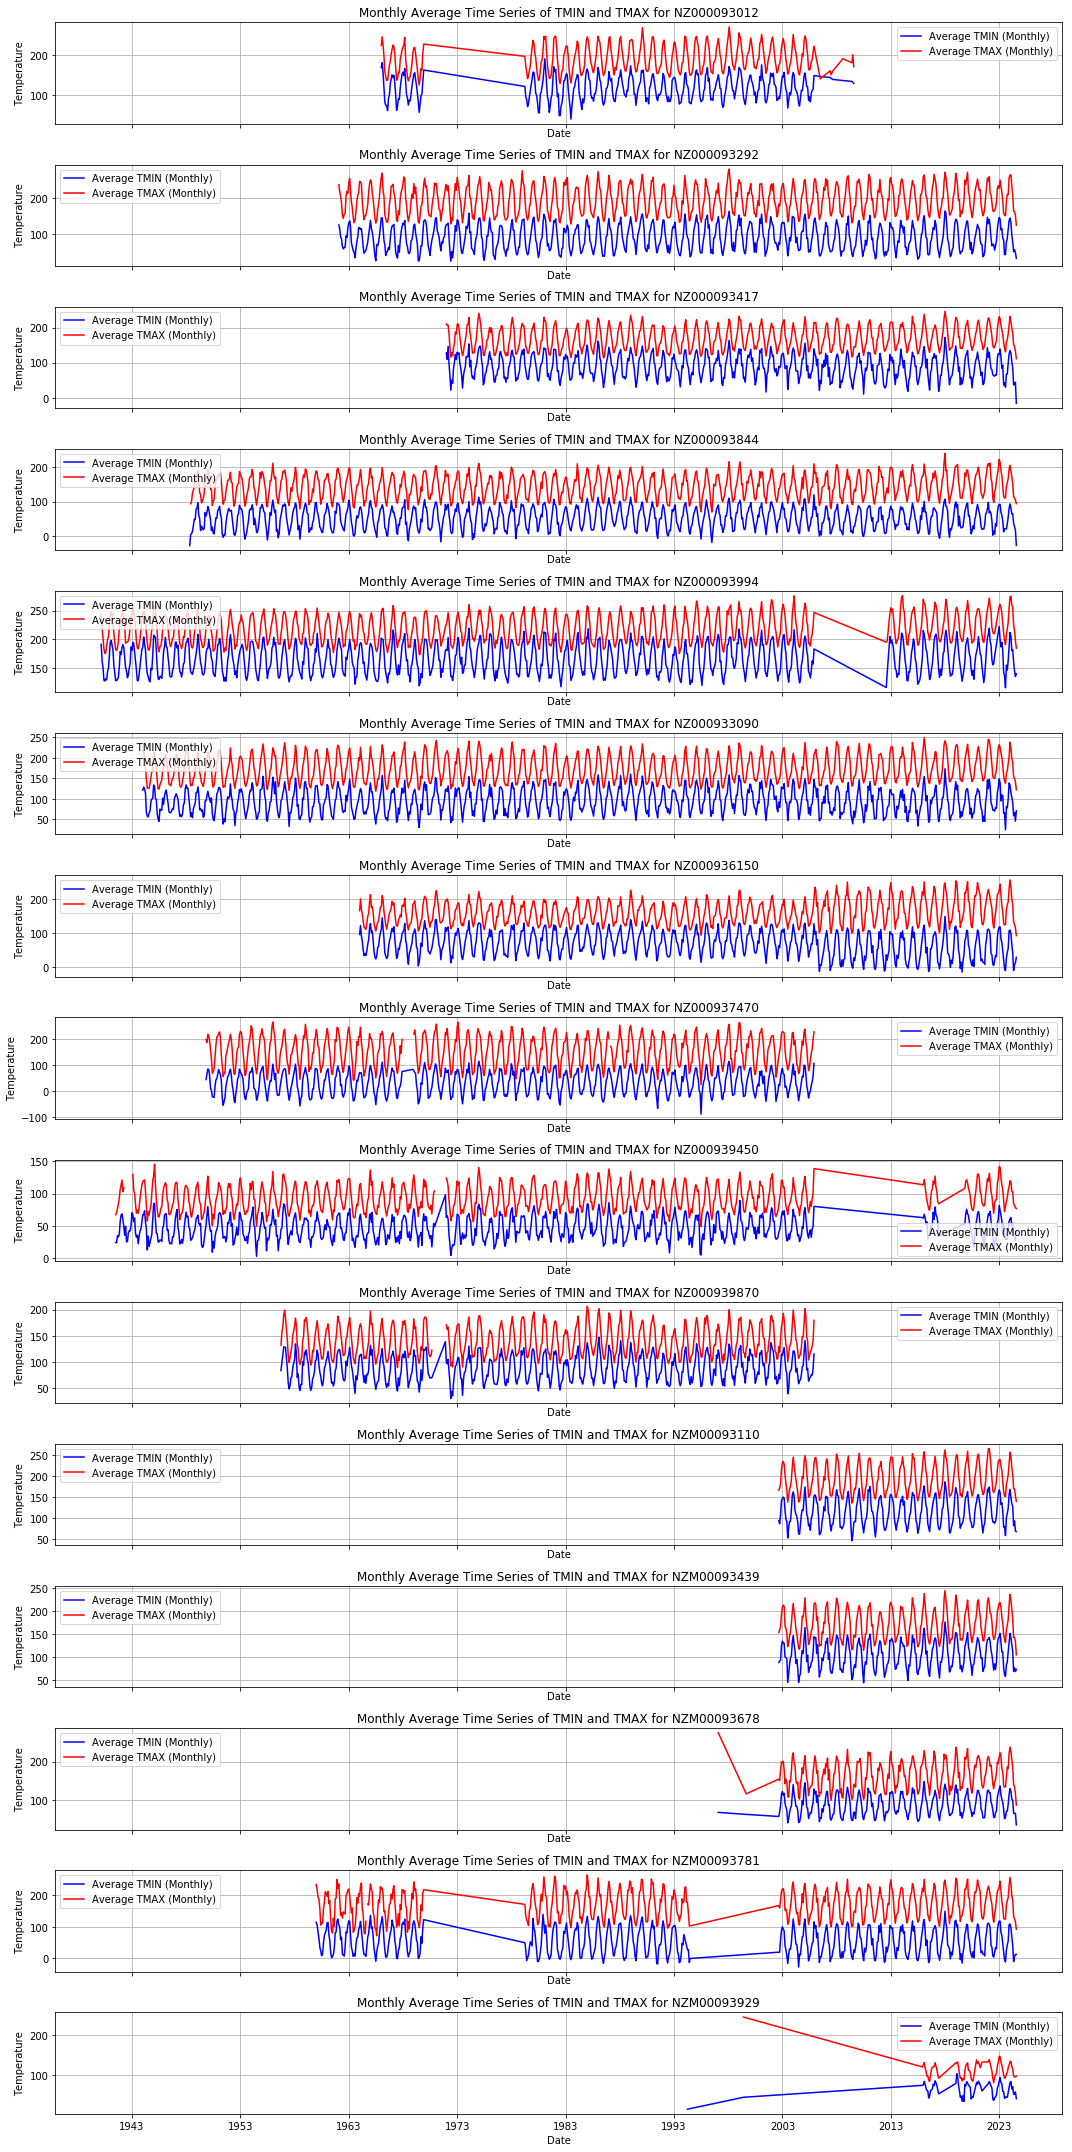

In [65]:
# Create subplots
stations = monthly_avg['ID'].unique()
num_stations = len(stations)
fig, axes = plt.subplots(num_stations, 1, figsize=(15, 2*num_stations), sharex=True)

if num_stations == 1:
    axes = [axes]  # Ensure axes is iterable if only one subplot

for ax, station in zip(axes, stations):
    station_data = monthly_avg[monthly_avg['ID'] == station]
    ax.plot(station_data['YearMonth'], station_data['TMIN_AVG_YM'], label='Average TMIN (Monthly)', color='blue')
    ax.plot(station_data['YearMonth'], station_data['TMAX_AVG_YM'], label='Average TMAX (Monthly)', color='red')
    ax.set_title(f"Monthly Average Time Series of TMIN and TMAX for {station}")
    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


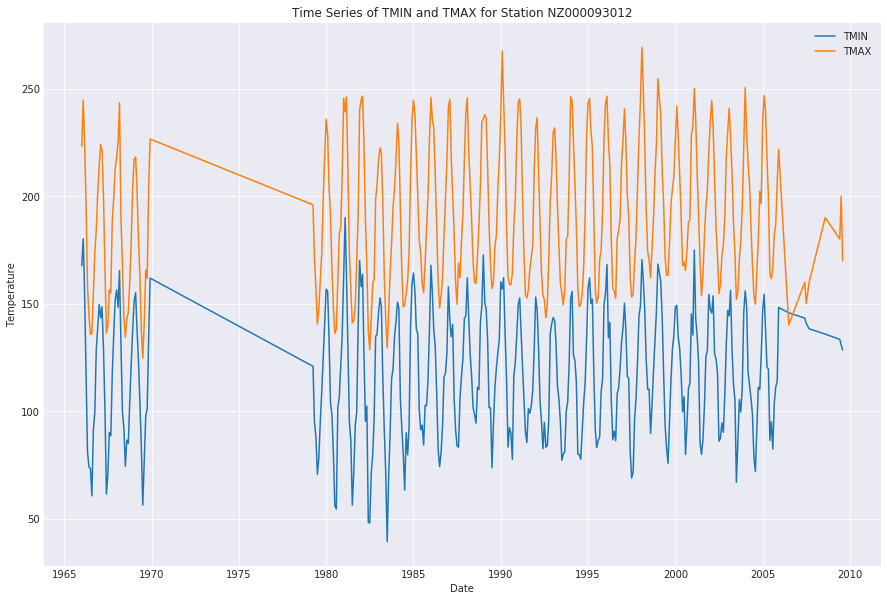

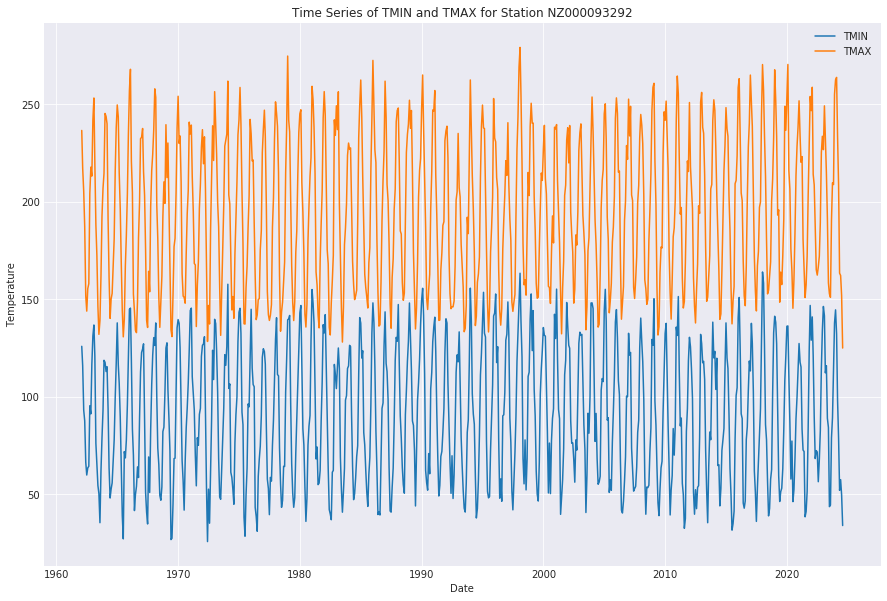

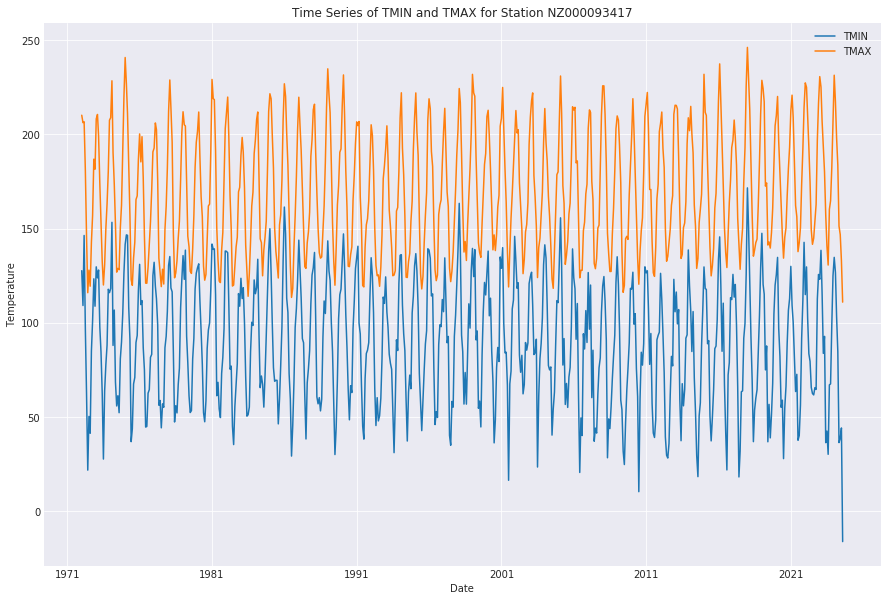

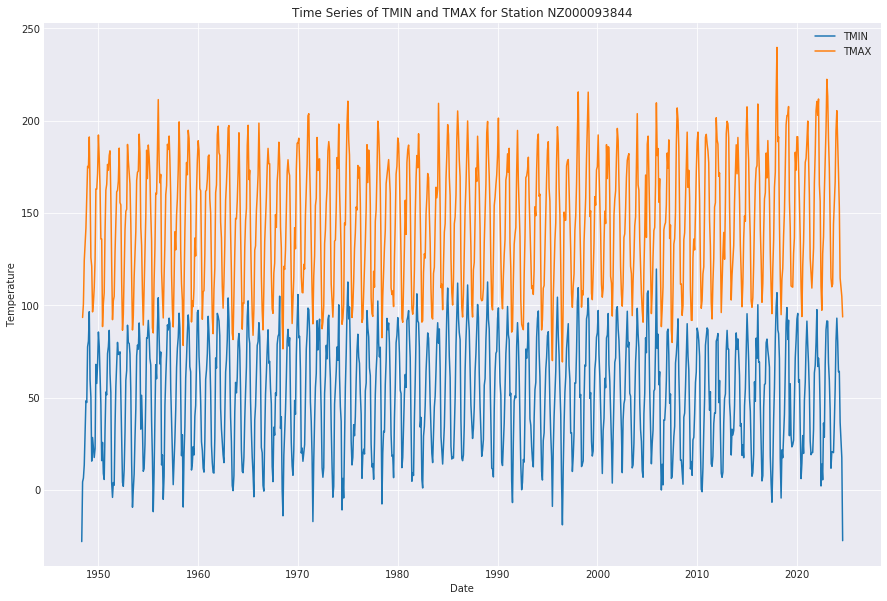

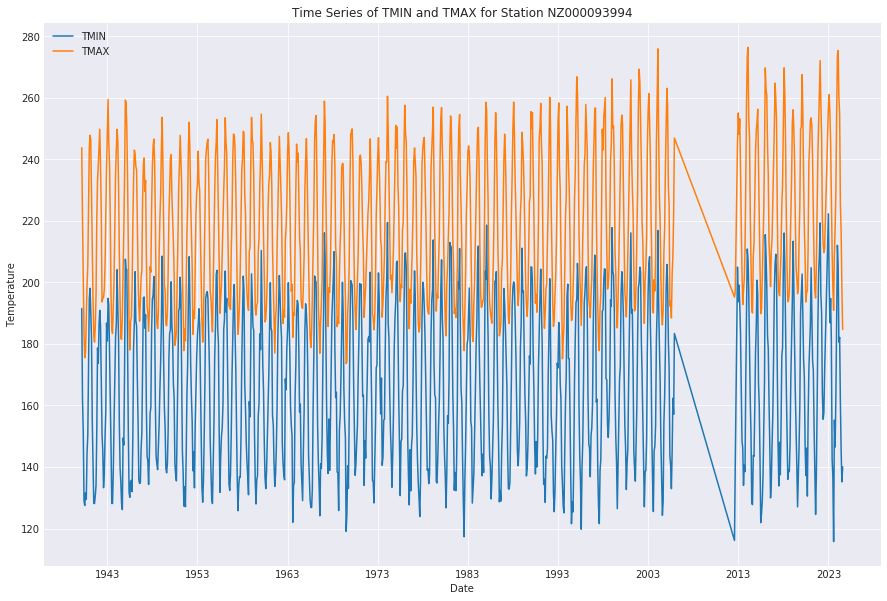

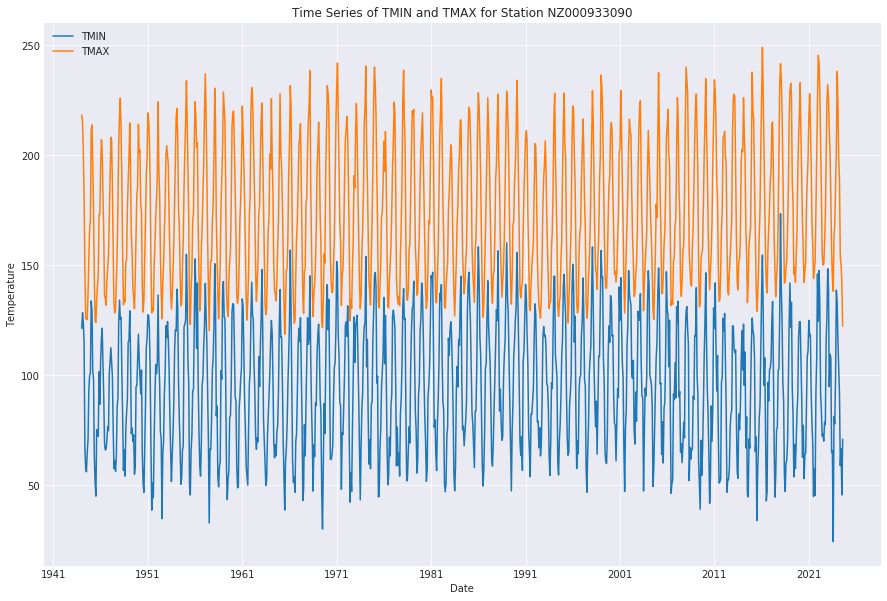

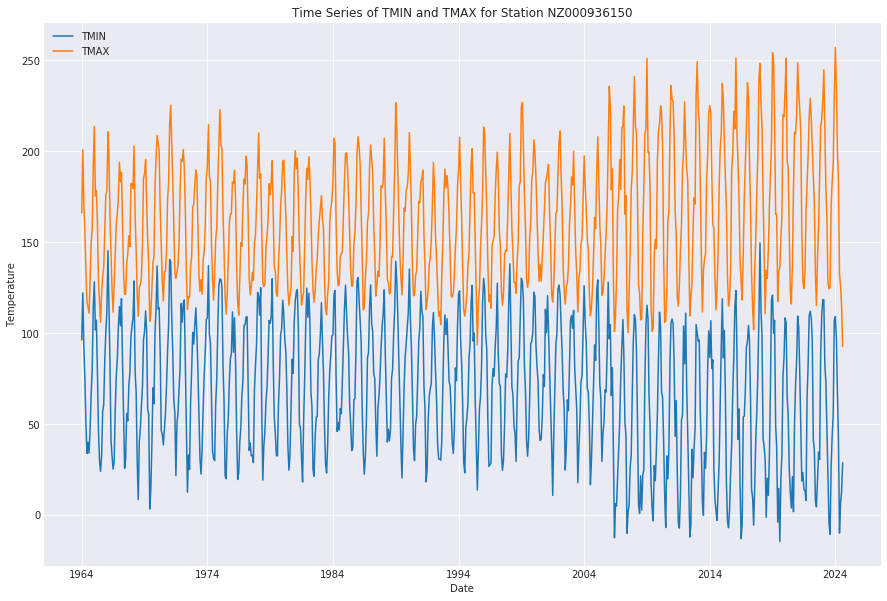

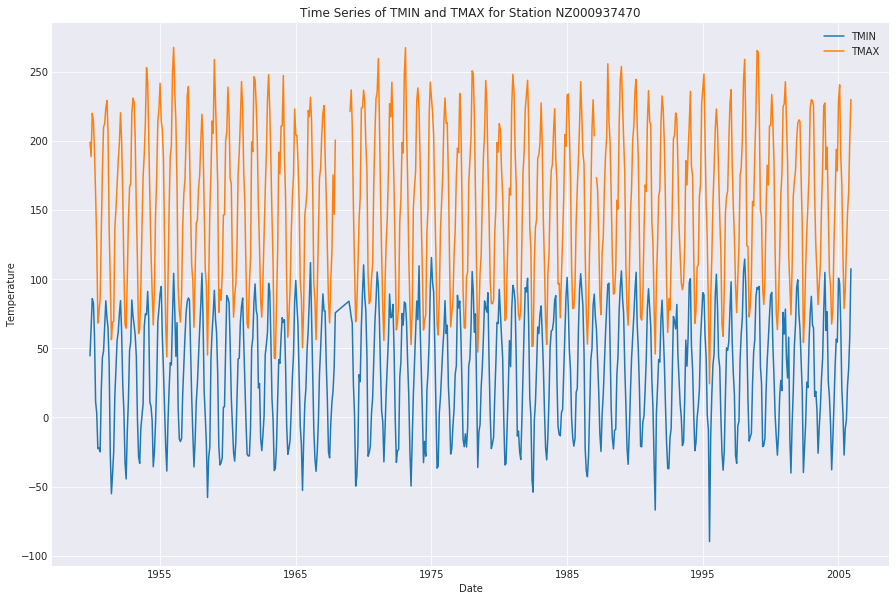

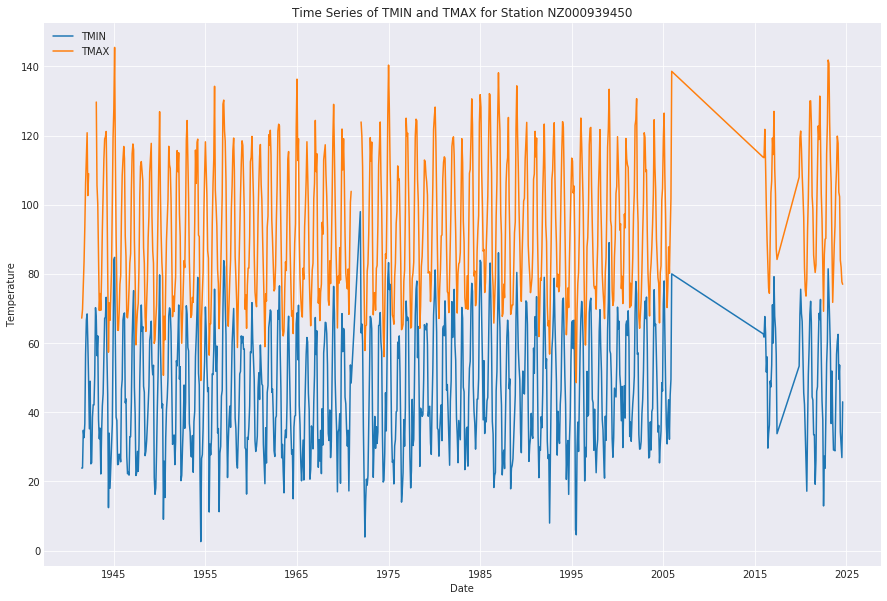

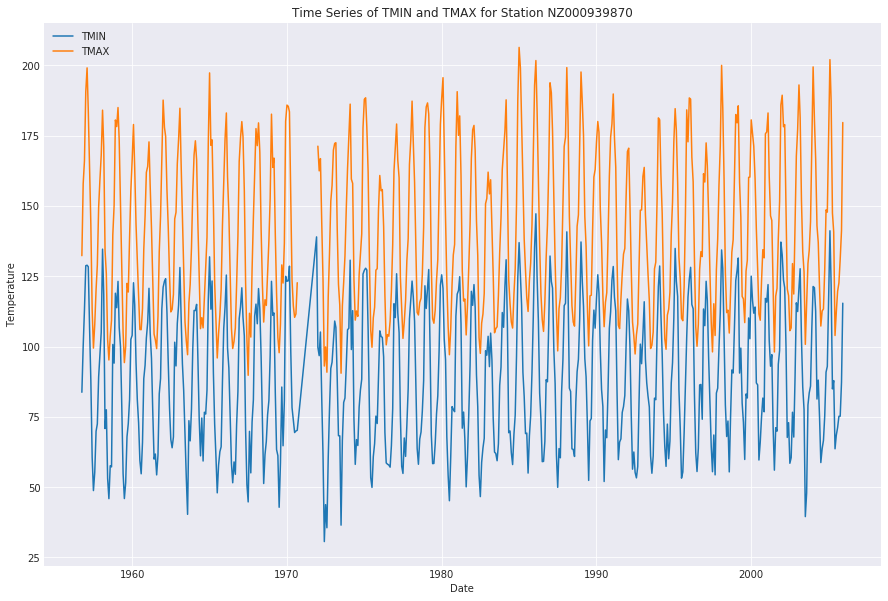

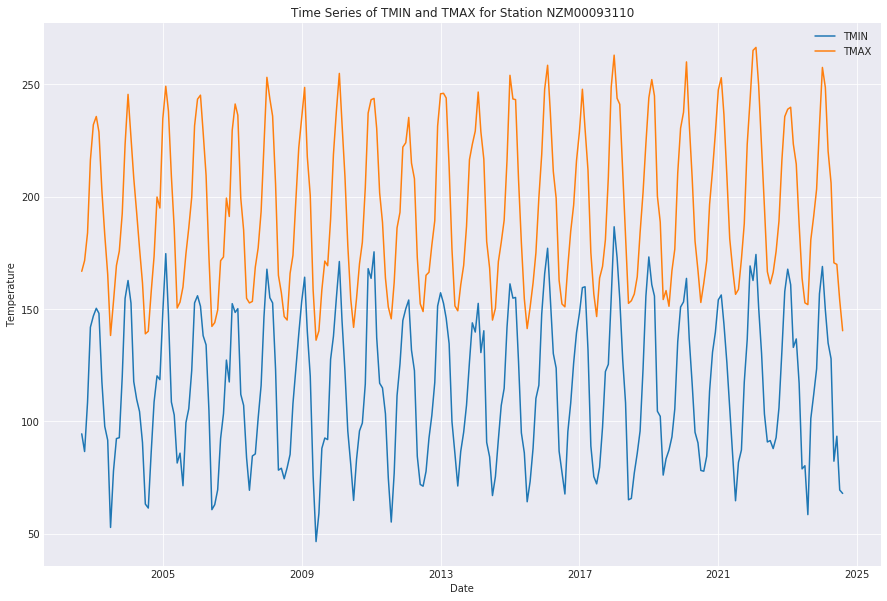

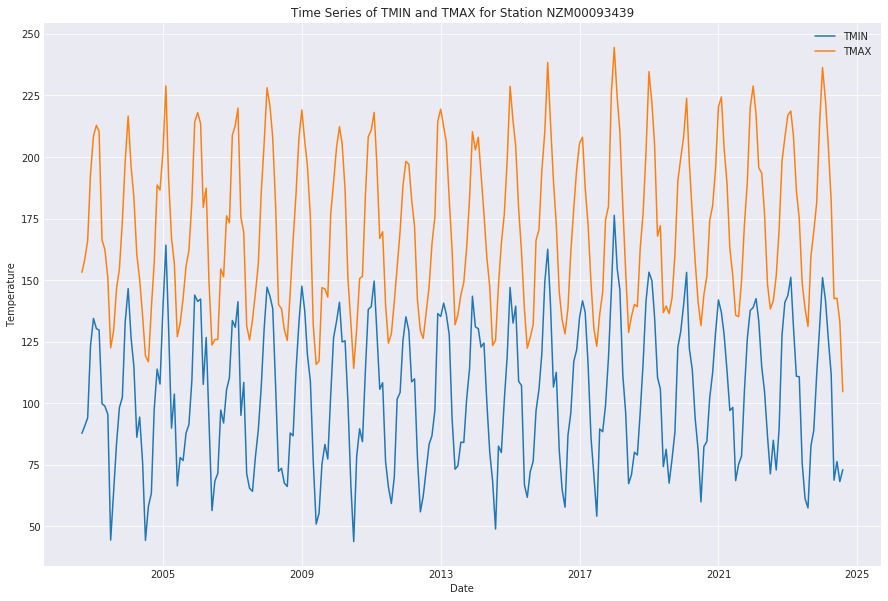

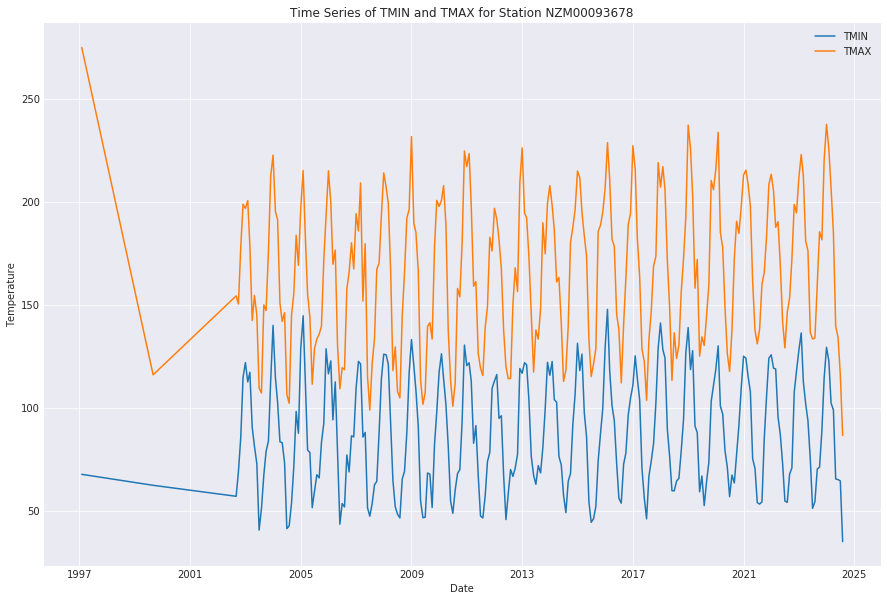

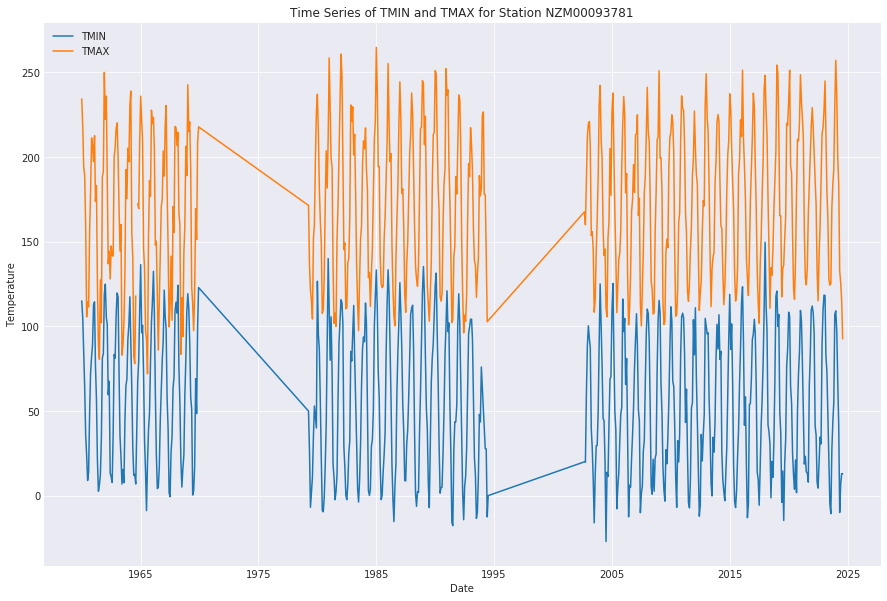

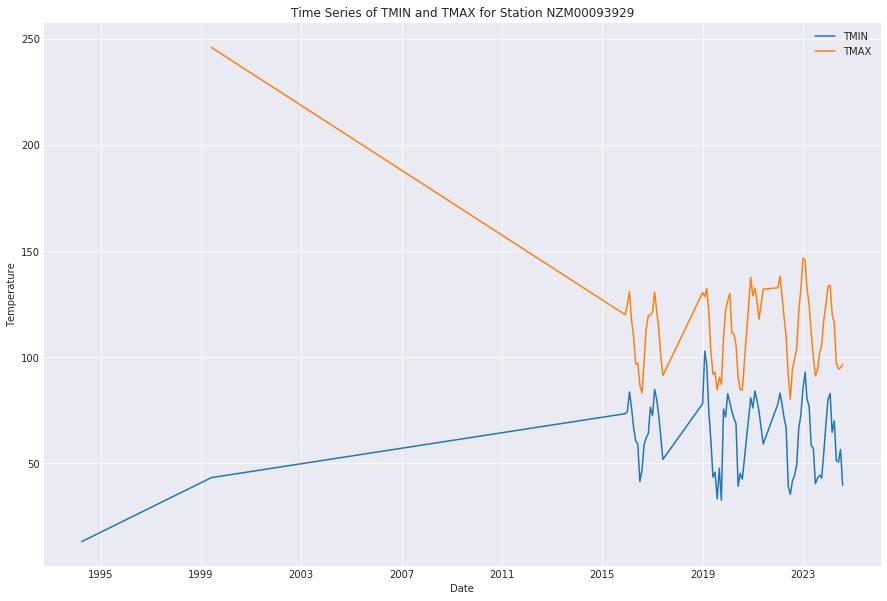

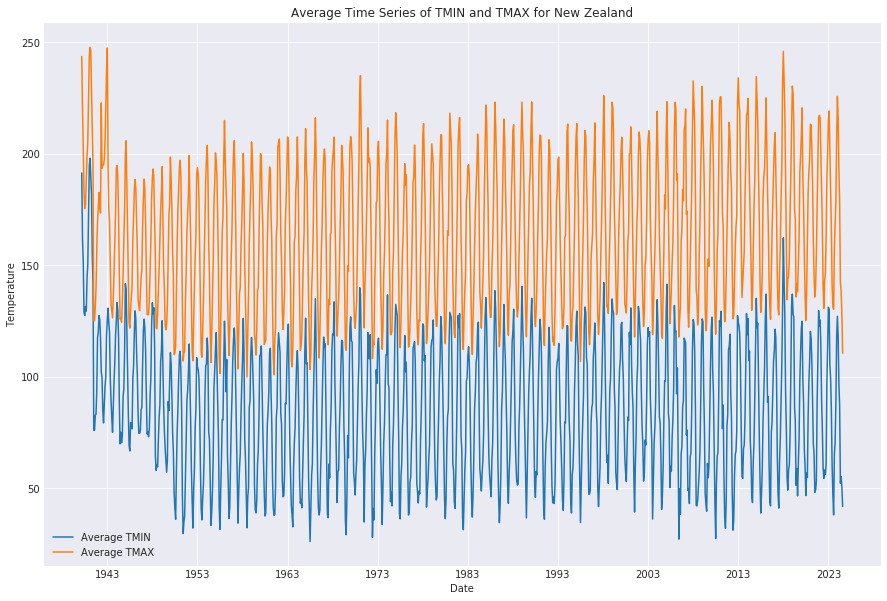

In [66]:
# Plot time series for each station
for station in monthly_avg['ID'].unique():
    station_data = monthly_avg[monthly_avg['ID'] == station]
    plt.figure(figsize=(15, 10))
    plt.style.use("seaborn-darkgrid")
    plt.plot(station_data['YearMonth'], station_data['TMIN_AVG_YM'], label='TMIN')
    plt.plot(station_data['YearMonth'], station_data['TMAX_AVG_YM'], label='TMAX')
    plt.title(f"Time Series of TMIN and TMAX for Station {station}")
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the average time series for all stations
avg_data = monthly_avg.groupby('YearMonth').mean().reset_index()
plt.figure(figsize=(15, 10))
plt.plot(avg_data['YearMonth'], avg_data['TMIN_AVG_YM'], label='Average TMIN')
plt.plot(avg_data['YearMonth'], avg_data['TMAX_AVG_YM'], label='Average TMAX')
plt.title("Average Time Series of TMIN and TMAX for New Zealand")
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

## Q2

In [67]:
daily_table_prcp = daily_table.filter(col("ELEMENT").isin("PRCP"))

In [68]:
show_as_html(daily_table_prcp)

ID      DATE ELEMENT  VALUE MEASUREMENT_FLAG QUALITY_FLAG  \
0   AEM00041194  20100101    PRCP    0.0             None         None   
1   AG000060390  20100101    PRCP    0.0             None         None   
2   AG000060590  20100101    PRCP    0.0             None         None   
3   AG000060611  20100101    PRCP    0.0             None         None   
4   AGE00147708  20100101    PRCP    5.0             None         None   
5   AGE00147716  20100101    PRCP    5.0             None         None   
6   AGE00147718  20100101    PRCP    0.0             None         None   
7   AGM00060351  20100101    PRCP    0.0             None         None   
8   AGM00060355  20100101    PRCP    0.0             None         None   
9   AGM00060360  20100101    PRCP    0.0             None         None   
10  AGM00060367  20100101    PRCP    0.0             None         None   
11  AGM00060369  20100101    PRCP    0.0             None         None   
12  AGM00060402  20100101    PRCP    0.0             None         None   
13  AGM00060403  20100101    PRCP    0.0             None         None   
14  AGM00060419  20100101    PRCP    0.0             None         None   
15  AGM00060421  20100101    PRCP    0.0             None         None   
16  AGM00060423  20100101    PRCP    0.0             None         None   
17  AGM00060425  20100101    PRCP   41.0             None         None   
18  AGM00060430  20100101    PRCP   30.0             None         None   
19  AGM00060437  20100101    PRCP   20.0             None         None   

   SOURCE_FLAG OBSERVATION_TIME  
0            S             None  
1            S             None  
2            S             None  
3            S             None  
4            S             None  
5            S             None  
6            S             None  
7            S             None  
8            S             None  
9            S             None  
10           S             None  
11           S             None  
12           S             None  
13           S             None  
14           S             None  
15           S             None  
16           S             None  
17           S             None  
18           S             None  
19           S             None

In [69]:
# Add year to it
daily_table_prcp = daily_table_prcp.withColumn('YEAR', F.substring('DATE', 1, 4))

In [70]:
# Group by 'ID' and 'Year' to compute the average precipitation
yearly_avg_prcp = daily_table_prcp.groupBy(['ID', 'YEAR']).agg(
    F.avg('VALUE').alias('AVG_PRCP')
)

# Add country code to it
yearly_avg_prcp = yearly_avg_prcp.withColumn("COUNTRY_CODE", F.substring("ID", 1, 2))

In [71]:
show_as_html(yearly_avg_prcp)

ID  YEAR    AVG_PRCP COUNTRY_CODE
0   AGM00060571  2011    3.966759           AG
1   ASN00003040  2011   34.119741           AS
2   ASN00003051  2011   42.394521           AS
3   ASN00003056  2011  102.225806           AS
4   ASN00004019  2011   15.103245           AS
5   ASN00006066  2011   59.956522           AS
6   ASN00009569  2011   21.368421           AS
7   ASN00009714  2011   21.250000           AS
8   ASN00009776  2011   18.972973           AS
9   ASN00009971  2011   23.736986           AS
10  ASN00010126  2011   11.586301           AS
11  ASN00014244  2011  142.258065           AS
12  ASN00014405  2011   60.757396           AS
13  ASN00014516  2011   64.735849           AS
14  ASN00014602  2011   73.534884           AS
15  ASN00014921  2011   40.090535           AS
16  ASN00015521  2011   15.706849           AS
17  ASN00022817  2011   20.099174           AS
18  ASN00023101  2011   13.380822           AS
19  ASN00023105  2011   14.060274           AS

In [72]:
# Saving it to output directory
yearly_avg_prcp.write.mode("overwrite").csv(f"{home_diretory}/Yearly_Average.csv", header=True)

In [73]:
# Convert to pandas
yearly_avg_prcp_pandas = yearly_avg_prcp.toPandas()

# Convert to date time format
#yearly_avg_prcp_pandas['DATE'] = yearly_avg_prcp_pandas.to_datetime(yearly_avg_prcp_pandas['DATE'])

# Extract year from 'DATE' for grouping
yearly_avg_prcp_pandas['YEAR'] = yearly_avg_prcp_pandas['YEAR'].astype(str)

# Sort values to ensure proper plotting order
yearly_avg_prcp_pandas = yearly_avg_prcp_pandas.sort_values(['ID', 'YEAR', "COUNTRY_CODE"])

# Group by 'ID' and 'Year' to compute the average TMIN and TMAX for each month
yearly_avg = yearly_avg_prcp_pandas.groupby(['YEAR', "COUNTRY_CODE"]).agg({
    'AVG_PRCP': 'mean'
}).rename(columns={'AVG_PRCP': 'PRCP_AVG/YR'}).reset_index()

In [74]:
display(yearly_avg)

YEAR COUNTRY_CODE  PRCP_AVG/YR
0      1750           AS    24.071181
1      1781           GM    24.558904
2      1782           GM    13.712329
3      1783           GM    17.832877
4      1784           GM    16.576503
5      1785           GM    16.169863
6      1786           GM    24.167123
7      1789           GM    18.476712
8      1790           GM    15.501370
9      1791           GM    17.475645
10     1792           GM    18.117486
11     1794           GM    20.753425
12     1795           GM    14.487671
13     1796           GM    14.444751
14     1797           GM    15.950685
15     1797           IT    12.446575
16     1798           GM    16.657534
17     1798           IT    13.408219
18     1800           GM    16.016438
19     1801           GM    19.416438
20     1802           GM    12.334247
21     1802           IT    10.424658
22     1803           GM    19.630137
23     1804           EZ    16.285714
24     1804           GM    17.426230
25     1805           EZ    11.827397
26     1805           GM    16.098630
27     1806           EZ    14.038922
28     1806           GM    12.823322
29     1807           EZ    14.632877
...     ...          ...          ...
17518  2024           SI    49.706431
17519  2024           SN   100.830986
17520  2024           SP    15.440323
17521  2024           SV     8.054056
17522  2024           SW    15.773943
17523  2024           SY    61.390000
17524  2024           SZ    40.566871
17525  2024           TD    26.419512
17526  2024           TH    83.865179
17527  2024           TI    72.164407
17528  2024           TO    71.395626
17529  2024           TS     4.773797
17530  2024           TU    29.465599
17531  2024           TV    80.353482
17532  2024           TX    58.124924
17533  2024           TZ   101.970475
17534  2024           UK    28.237198
17535  2024           UP    49.320133
17536  2024           US    44.953654
17537  2024           UV    47.507515
17538  2024           UY    72.617330
17539  2024           UZ    39.565903
17540  2024           VE    48.169014
17541  2024           VM    47.523327
17542  2024           VQ    46.856870
17543  2024           WA    36.005573
17544  2024           WF    72.029557
17545  2024           WQ    20.117188
17546  2024           ZA   111.300000
17547  2024           ZI    25.902980

[17548 rows x 3 columns]

In [77]:
# Convert the Pandas DataFrame to a PySpark DataFrame
yearly_avg_spark = spark.createDataFrame(yearly_avg)
yearly_avg_spark.write.mode("overwrite").parquet(f"{home_diretory}/Yearly_Average_Precipitate.parquet")

In [79]:
rainfall_stats = yearly_avg["PRCP_AVG/YR"].describe()

print(rainfall_stats)

count    17548.000000
mean        43.767694
std         88.663266
min         -1.076712
25%         15.746514
50%         26.008696
75%         49.643417
max       4361.000000
Name: PRCP_AVG/YR, dtype: float64


In [88]:
# Find the row with the maximum average precipitation
max_rainfall_row = yearly_avg.loc[yearly_avg['PRCP_AVG/YR'].idxmax()]

# Get the country and year with the highest average rainfall
highest_rainfall_country = max_rainfall_row['COUNTRY_CODE']
highest_rainfall_year = max_rainfall_row['YEAR']
highest_rainfall_value = max_rainfall_row['PRCP_AVG/YR']

country_name = country.filter(col("CODE")== highest_rainfall_country).select("NAME").collect()

# Display the result
print(f"The country with the highest average rainfall in a single year is {country_name[0]['NAME']} in the year {highest_rainfall_year}, with an average rainfall of {highest_rainfall_value:.2f} mm.")

The country with the highest average rainfall in a single year is Equatorial Guinea in the year 2000, with an average rainfall of 4361.00 mm.


In [116]:
# Filter the dataframe to only include rows where YEAR is '2023'
rainfall_2023 = yearly_avg[yearly_avg['YEAR'] == '2023'][['COUNTRY_CODE', 'PRCP_AVG/YR']]

In [108]:
display(rainfall_2023)

COUNTRY_CODE  PRCP_AVG/YR
17188           AE    19.599916
17189           AG     8.828681
17190           AJ   113.552582
17191           AM    70.930970
17192           AQ    99.293836
17193           AR    50.748726
17194           AS    20.334032
17195           AU    39.804086
17196           AY    13.268750
17197           BA    12.446809
17198           BC    15.632316
17199           BD    60.126506
17200           BE    29.274286
17201           BF    77.386996
17202           BG    75.204669
17203           BH    47.169492
17204           BK    38.979771
17205           BL    92.789338
17206           BM   128.999626
17207           BN    67.356721
17208           BO    42.554124
17209           BP    80.536465
17210           BR    63.558150
17211           BU    15.363806
17212           BX    91.812721
17213           CA    28.081542
17214           CB    58.492212
17215           CD   108.055269
17216           CE    63.696679
17217           CF    81.097542
...            ...          ...
17340           SN    89.494208
17341           SP    13.454782
17342           SU   227.000000
17343           SV    11.590289
17344           SW    21.250106
17345           SY    60.551389
17346           SZ    38.026355
17347           TD    38.463068
17348           TH    92.052638
17349           TI    68.858200
17350           TO    48.220630
17351           TS     6.934823
17352           TU    35.402992
17353           TV    63.420469
17354           TX    48.816819
17355           TZ   103.006520
17356           UK    29.852196
17357           UP    52.197078
17358           US    38.965757
17359           UV    62.623257
17360           UY    77.823839
17361           UZ    89.096080
17362           VE    25.483516
17363           VM    58.908716
17364           VQ    27.214407
17365           WA    35.090645
17366           WF    76.229917
17367           WQ    29.705882
17368           ZA    40.355556
17369           ZI    73.346907

[182 rows x 2 columns]

In [111]:
# Convert to DataFrame
country_pandas= country.toPandas()
display(country_pandas)

CODE                                               NAME  STATION_COUNT
0     SW                                            Sweden            1721
1     BL                                           Bolivia              36
2     IR                                              Iran              35
3     WZ                                         Swaziland               6
4     EK                                  Equatorial Guinea              2
5     AG                                           Algeria              87
6     AS                                         Australia           17088
7     CE                                         Sri Lanka               6
8     MR                                        Mauritania              19
9     NH                                           Vanuatu               6
10    RW                                             Rwanda              1
11    BN                                             Benin               9
12    CH                                            China              228
13    SY                                             Syria              12
14    NC                            New Caledonia [France]               3
15    TL                             Tokelau [New Zealand]               1
16    MP                                         Mauritius               5
17    PK                                          Pakistan              35
18    GB                                             Gabon              20
19    NP                                             Nepal               2
20    PS                                              Palau             12
21    BM                                              Burma              5
22    KT                      Christmas Island [Australia]               1
23    SP                                             Spain             207
24    AJ                                        Azerbaijan              66
25    AU                                           Austria              13
26    RQ                       Puerto Rico [United States]             253
27    TZ                                          Tanzania              14
28    SX  South Georgia and the South Sandwich Islands [...              2
29    NS                                           Suriname              1
..   ...                                                ...            ...
189   SH                     Saint Helena [United Kingdom]               4
190   GG                                            Georgia            103
191   IV                                     Cote D'Ivoire              21
192   LE                                            Lebanon              8
193   SN                                          Singapore              1
194   KZ                                        Kazakhstan             329
195   DR                                Dominican Republic               5
196   JU                       Juan De Nova Island [France]              1
197   IT                                             Italy             104
198   PO                                          Portugal              26
199   WA                                           Namibia             283
200   EC                                           Ecuador              15
201   ML                                              Mali              19
202   MB                                Martinique [France]              2
203   PC                 Pitcairn Islands [United Kingdom]               1
204   FI                                           Finland             922
205   RP                                       Philippines              34
206   PL                                            Poland              10
207   IN                                             India            3807
208   LG                                            Latvia              32
209   SU                                             Sudan              28
210   SF                     

In [117]:
# Merge on 'COUNTRY_CODE' and 'CODE'
rainfall_2023 = pd.merge(rainfall_2023, country_pandas, left_on='COUNTRY_CODE', right_on='CODE', how='left')

# Drop the redundant 'CODE' column if needed
rainfall_2023 = rainfall_2023.drop(columns=['CODE', "STATION_COUNT"])

display(rainfall_2023)

COUNTRY_CODE  PRCP_AVG/YR                             NAME
0             AE    19.599916            United Arab Emirates 
1             AG     8.828681                         Algeria 
2             AJ   113.552582                      Azerbaijan 
3             AM    70.930970                         Armenia 
4             AQ    99.293836  American Samoa [United States] 
5             AR    50.748726                       Argentina 
6             AS    20.334032                       Australia 
7             AU    39.804086                         Austria 
8             AY    13.268750                      Antarctica 
9             BA    12.446809                         Bahrain 
10            BC    15.632316                        Botswana 
11            BD    60.126506        Bermuda [United Kingdom] 
12            BE    29.274286                         Belgium 
13            BF    77.386996                    Bahamas, The 
14            BG    75.204669                       Bangladesh
15            BH    47.169492                           Belize
16            BK    38.979771          Bosnia and Herzegovina 
17            BL    92.789338                         Bolivia 
18            BM   128.999626                            Burma
19            BN    67.356721                           Benin 
20            BO    42.554124                         Belarus 
21            BP    80.536465                 Solomon Islands 
22            BR    63.558150                           Brazil
23            BU    15.363806                         Bulgaria
24            BX    91.812721                           Brunei
25            CA    28.081542                          Canada 
26            CB    58.492212                         Cambodia
27            CD   108.055269                            Chad 
28            CE    63.696679                       Sri Lanka 
29            CF    81.097542             Congo (Brazzaville) 
..           ...          ...                              ...
152           SN    89.494208                        Singapore
153           SP    13.454782                           Spain 
154           SU   227.000000                           Sudan 
155           SV    11.590289               Svalbard [Norway] 
156           SW    21.250106                          Sweden 
157           SY    60.551389                           Syria 
158           SZ    38.026355                     Switzerland 
159           TD    38.463068             Trinidad and Tobago 
160           TH    92.052638                        Thailand 
161           TI    68.858200                      Tajikistan 
162           TO    48.220630                            Togo 
163           TS     6.934823                         Tunisia 
164           TU    35.402992                          Turkey 
165           TV    63.420469                          Tuvalu 
166           TX    48.816819                    Turkmenistan 
167           TZ   103.006520                        Tanzania 
168           UK    29.852196                  United Kingdom 
169           UP    52.197078                         Ukraine 
170           US    38.965757                   United States 
171           UV    62.623257                    Burkina Faso 
172           UY    77.823839                         Uruguay 
173           UZ    89.096080                      Uzbekistan 
174           VE    25.483516                       Venezuela 
175           VM    58.908716                         Vietnam 
176           VQ    27.214407  Virgin Islands [United States] 
177           WA    35.090645                         Namibia 
178           WF    76.229917       Wallis and Futuna [France]
179           WQ    29.705882      Wake Island [United States]
180           ZA    40.355556                          Zambia 
181           ZI    73.346907                        Zimbabwe 

[182 rows x 3 columns]

In [119]:
# Aggregated data
rainfall_grouped = rainfall_2023.groupby('NAME').agg({'PRCP_AVG/YR': 'mean'}).reset_index()

In [122]:
# Plotly Choropleth Map
fig = px.choropleth(
    rainfall_grouped,
    locations="NAME",          # Column with country names
    locationmode="country names",       # Use country names for the location mode
    color="PRCP_AVG/YR",                # Column with average rainfall data
    title="Average Rainfall in 2023 by Country",
    color_continuous_scale="Blues",
    labels={'PRCP_AVG/YR': 'Average Rainfall (mm)'}
)

# Show the figure
fig.show()

In [123]:
# Check for missing values
missing_values = rainfall_grouped.isna().sum()

# Print the missing values
print(missing_values)

NAME           0
PRCP_AVG/YR    0
dtype: int64


In [124]:
# To see rows with missing values
rows_with_missing = rainfall_grouped[rainfall_grouped.isna().any(axis=1)]

# Print rows with missing values
print(rows_with_missing)

Empty DataFrame
Columns: [NAME, PRCP_AVG/YR]
Index: []


In [184]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

#stop_spark()